# Proximal Policy Optimization for Pendulum

## 1. Proximal Policy Optimization

**Proximal Policy Optimization** is a **new family of policy gradient methods for reinforcement learning**, which alternate between **sampling data through interaction with the environment, and optimizing a "surrogate" objective function using stochastic gradient ascent.** 

Whereas **standard** policy gradient methods perform **one gradient update per data sample**, here a novel objective function that enables **multiple epochs of minibatch updates** is used. 

The new methods are called Proximal Policy Optimization (PPO), and have some of the benefits of trust region policy optimization (TRPO), but are much simpler to implement, more general, and have better sample complexity (empirically).

[1]

### 1.1 PPO Algorithm

<img src="src/ppo_algorithm.png", width="500px">

[1]

## 2. Implementation of PPO

### 2.1 Imports

In [1]:
import tensorflow as tf
import numpy as np
import gym
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# Imports specifically so we can render outputs in Jupyter.
import matplotlib.pyplot as plt
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

### 2.2 Util functions (display)

In [2]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

### 2.3 Hyperparameters

*EP_MAX* = Number of epochs for training<br>
*EP_LEN* = Max length of each episode<br>
*GAMMA* = Discount factor<br>
*A_LR* = Actor Learning Rate<br>
*C_LR* = Critic Learning Rate<br>
*BATCH* = Batch size<br>
*A_UPDATE_STEPS* = Actor number of update steps<br>
*C_UPDATE_STEPS* = Critic number of update steps<br>
*S_DIM, A_DIM* = Size of layers<br>
*METHOD* = Select the approach. Clipped Surrogate Objective or Adaptive KL Penalty Coefficient<br>

In [3]:
EP_MAX = 1000
EP_LEN = 200
GAMMA = 0.9
A_LR = 0.0001
C_LR = 0.0002
BATCH = 32
A_UPDATE_STEPS = 10
C_UPDATE_STEPS = 10
S_DIM, A_DIM = 3,1
METHOD = [
    dict(name='kl_pen', kl_target=0.01, lam=0.5),
    dict(name='clip',epsilon=0.2),
][1]

### 2.4 PPO algorithm implementation

In [4]:
class PPO(object):
    
    def __init__(self):
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32,[None, S_DIM], 'state')
        
        #Critic
        with tf.variable_scope('critic'):
            l1 = tf.layers.dense(self.tfs, 100, tf.nn.relu)
            self.v = tf.layers.dense(l1,1)
            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.advantage = self.tfdc_r - self.v
            self.closs = tf.reduce_mean(tf.square(self.advantage))
            self.ctrain_op = tf.train.AdamOptimizer(C_LR).minimize(self.closs)
                
        #Actor
        pi, pi_params = self._build_anet('pi', trainable=True)
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(pi.sample(1),axis=0) #Choose action
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]
        
        self.tfa = tf.placeholder(tf.float32,[None, A_DIM],'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
        
        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate'):
                ratio = pi.prob(self.tfa) / oldpi.prob(self.tfa)
                surr = ratio * self.tfadv
                
            if METHOD['name'] == 'kl_pen':
                self.tflam = tf.placeholder(tf.float32, None, 'lambda')
                kl = tf.contrib.distributions.kl_divergence(oldpi, pi)
                self.kl_mean = tf.reduce_mean(kl)
                self.aloss = -(tf.reduce_mean(surr - self.tflam * kl))
            else:
                self.aloss = -tf.reduce_mean(tf.minimum(surr,
                                                       tf.clip_by_value(ratio, 1.-METHOD['epsilon'], 1.+METHOD['epsilon'])*self.tfadv
                                                       )
                                            )
        with tf.variable_scope('atrain'):
            self.atrain_op = tf.train.AdamOptimizer(A_LR).minimize(self.aloss)

        tf.summary.FileWriter("log/", self.sess.graph)
        
        self.sess.run(tf.global_variables_initializer())
        
    
    def update(self, s, a, r):
        self.sess.run(self.update_oldpi_op)
        adv = self.sess.run(self.advantage, {self.tfs: s, self.tfdc_r: r})
        
        #Update actor
        if METHOD['name'] == 'kl_pen':
            for _ in range(A_UPDATE_STEPS):
                _, kl = self.sess.run([self.atrain_op, self.kl_mean],
                                     {self.tfs: s, self.tfa: a, self.tfadv: adv, self.tflam: METHOD['lam']})
                if kl > 4*METHOD['kl_target']:
                    break
            if kl < METHOD['kl_target'] / 1.5: 
                METHOD['lam'] /= 2
            elif kl > METHOD['kl_target'] * 1.5:
                METHOD['lam'] *= 2
            METHOD['lam'] = np.clip(METHOD['lam'], 1e-4, 10)
        else:
            [self.sess.run(self.atrain_op, {self.tfs: s, self.tfa: a, self.tfadv: adv}) for _ in range(A_UPDATE_STEPS)]
        
        #Update critic
        [self.sess.run(self.ctrain_op, {self.tfs: s, self.tfdc_r: r}) for _ in range(C_UPDATE_STEPS)]
        
    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            l1 = tf.layers.dense(self.tfs, 100, tf.nn.relu, trainable=trainable)
            mu = 2 * tf.layers.dense(l1, A_DIM, tf.nn.tanh, trainable=trainable)
            sigma = tf.layers.dense(l1, A_DIM, tf.nn.softplus, trainable=trainable)
            norm_dist = tf.contrib.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params
    
    def choose_action(self, s):
        s = s[np.newaxis, :]
        a = self.sess.run(self.sample_op, {self.tfs: s})[0]
        return np.clip(a, -2, 2)
    
    def get_v(self, s):
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v, {self.tfs: s})[0,0]

### 2.5 Train function implementation

Just the function to iterate and perform the training phase.

All episode rewards are stored on *all_ep_r* and returned in order to inspect them (plot). 

Also the graph is saved in the *log* folder at the same path this IPYNB is located.

In [5]:
def train(env, ppo, epochs,render=False):
    all_ep_r = []
    frames = []
    display_freq = EP_MAX//10
    
    for ep in range(epochs):
        s = env.reset()
        
        buffer_s, buffer_a, buffer_r = [],[],[]
        ep_r = 0
        for t in range(EP_LEN):
            if (render and (ep == epochs-1)):
                frames.append(env.render(mode = 'rgb_array'))
            a = ppo.choose_action(s)
            s_, r, done, _ = env.step(a)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append((r+8)/8)
            s = s_
            ep_r += r
            
            #Udpate ppo
            if (t+1) % BATCH == 0 or t == EP_LEN - 1:
                v_s_ = ppo.get_v(s_)
                discounted_r = []
                for r in buffer_r[::-1]:
                    v_s_ = r + GAMMA * v_s_
                    discounted_r.append(v_s_)
                discounted_r.reverse()
                
                bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.array(discounted_r)[:, np.newaxis]
                buffer_s, buffer_a, buffer_r = [],[],[]
                ppo.update(bs, ba, br)
                
        if ep == 0: all_ep_r.append(ep_r)
        else: all_ep_r.append(all_ep_r[-1]*0.9 + ep_r*0.1)
        
        if(ep % display_freq == 0):
            print('At epoch %d - Ep. Reward %i' %(ep, ep_r))
        
    if render:
        env.render(close=True)
        display_frames_as_gif(frames)
        
    return all_ep_r

## 3. Train

First of all, create an instance on the **Environment** and the **PPO** class.

In [6]:
env = gym.make('Pendulum-v0').unwrapped
ppo = PPO()

[2017-12-24 18:13:05,178] Making new env: Pendulum-v0


### 3.1 Render a test episode

At epoch 0 - Ep. Reward -1253



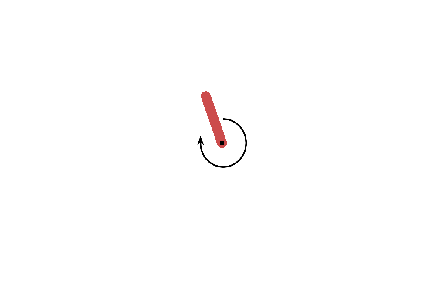
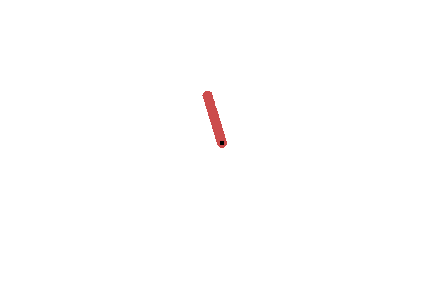
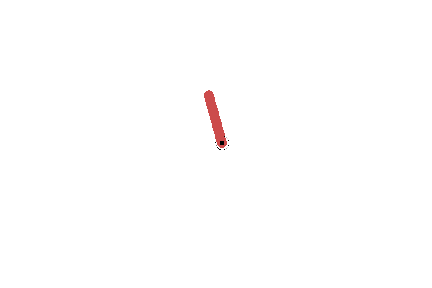
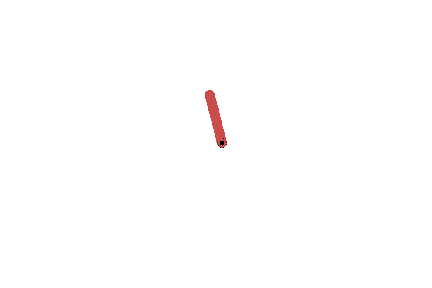
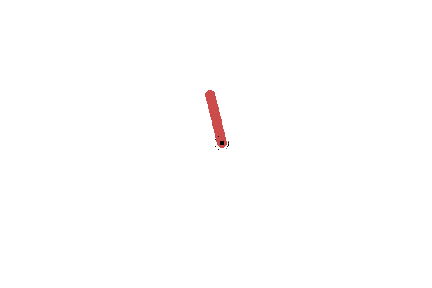
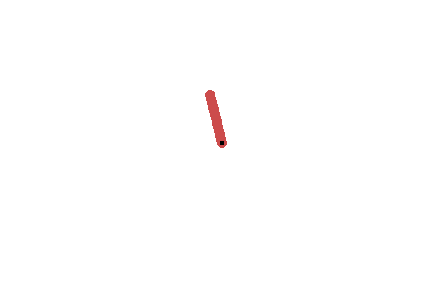
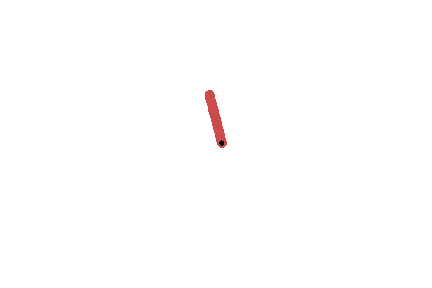
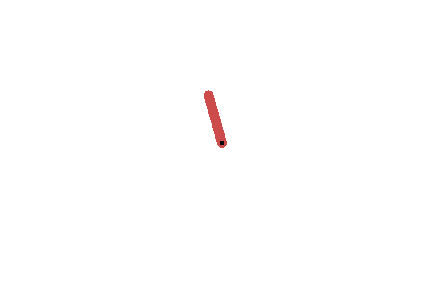
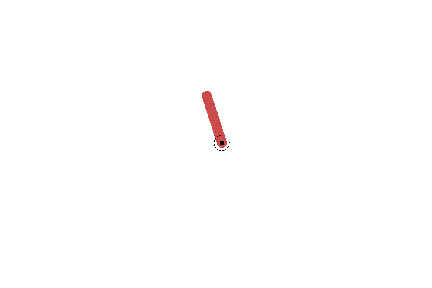
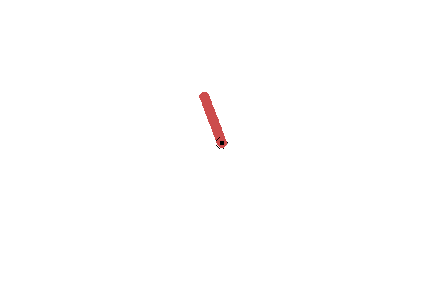
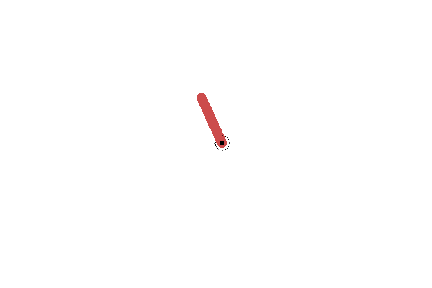
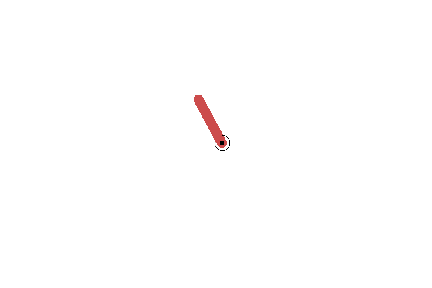
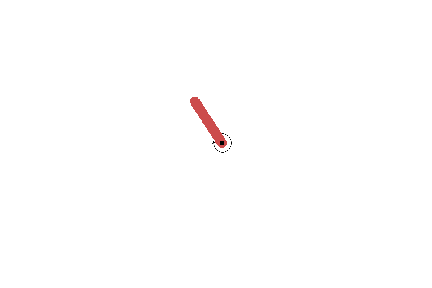
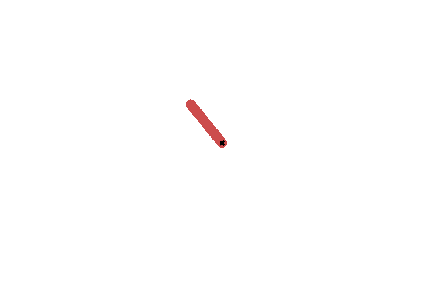
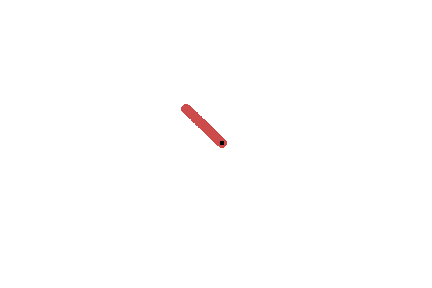
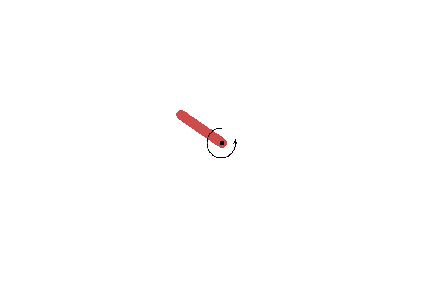
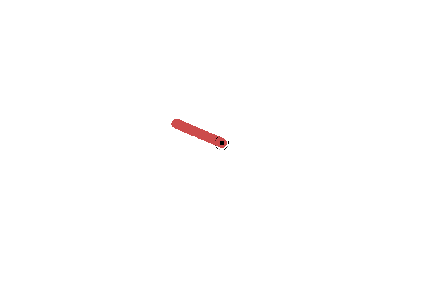
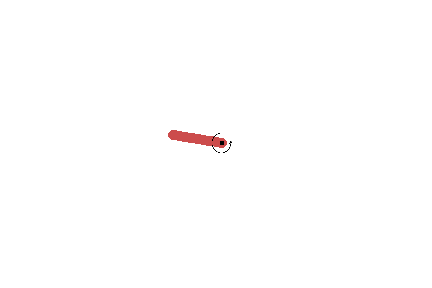
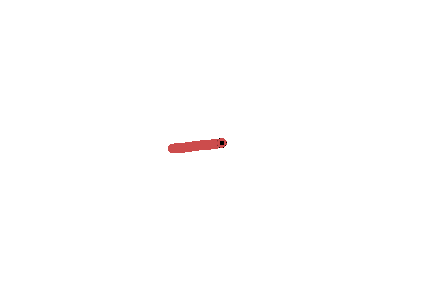
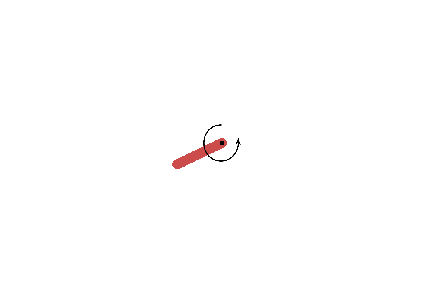
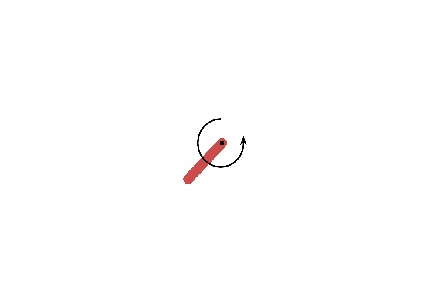
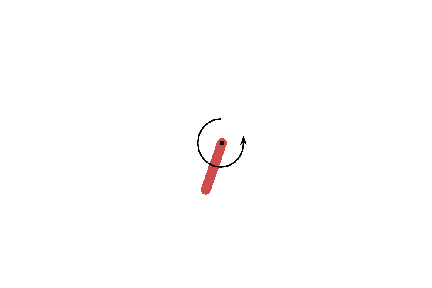
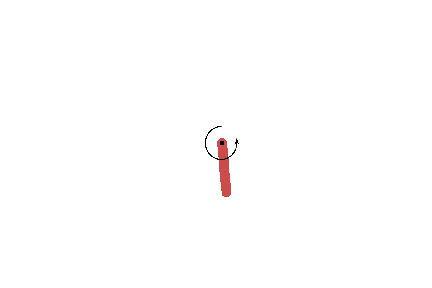
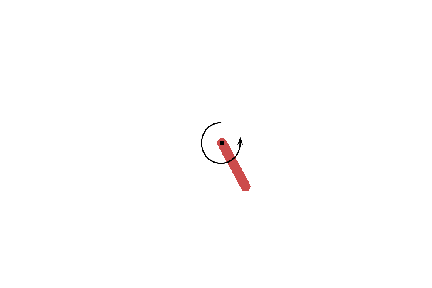
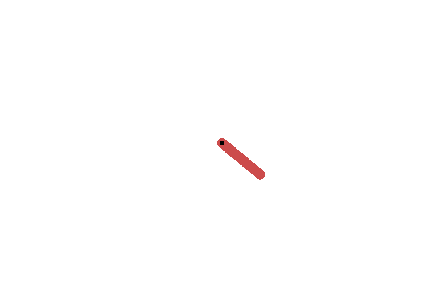
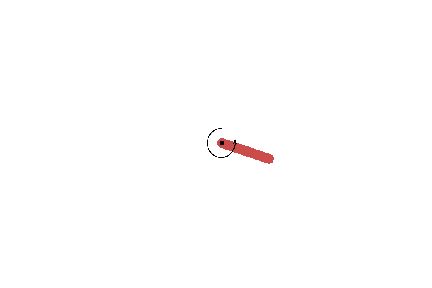
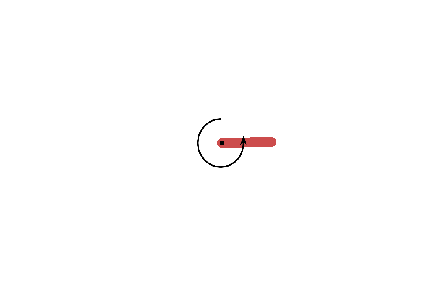
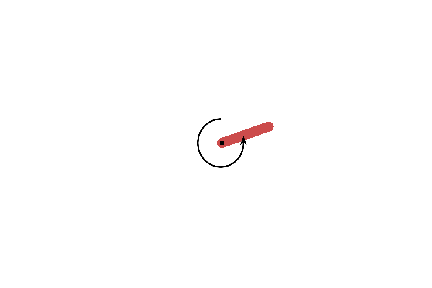
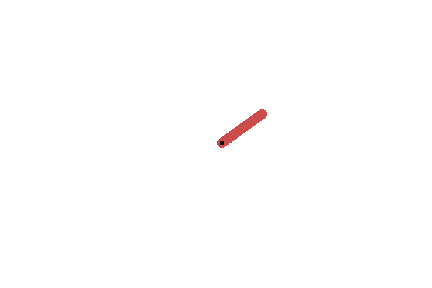
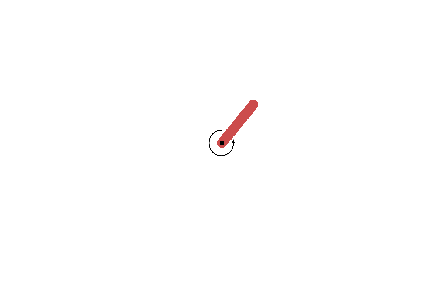
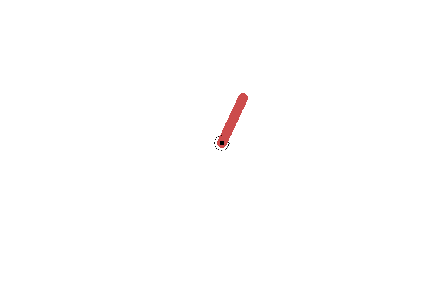
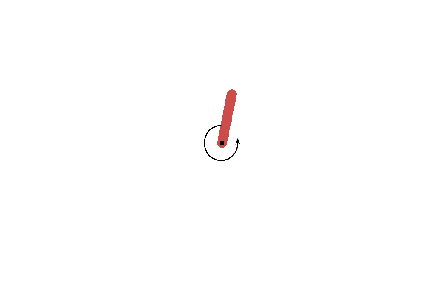
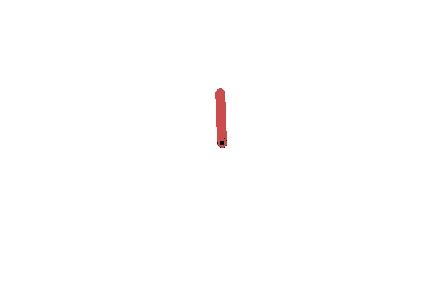
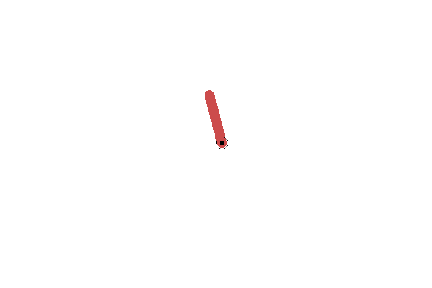
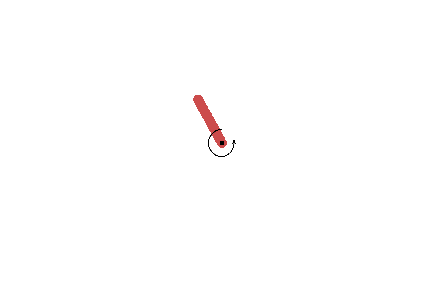
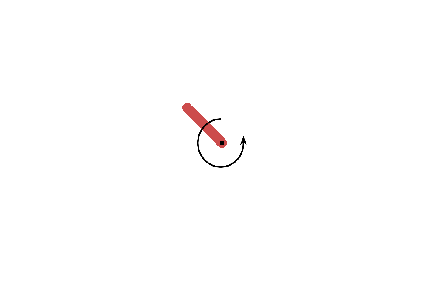
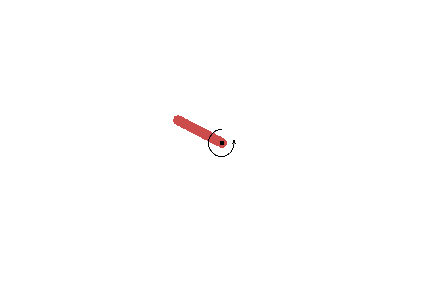
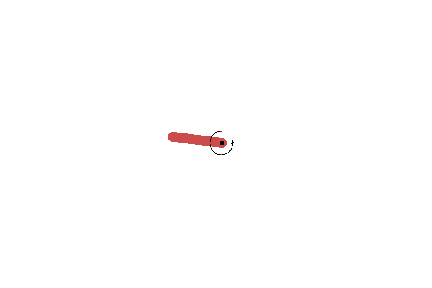
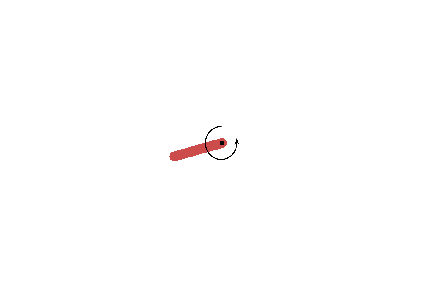
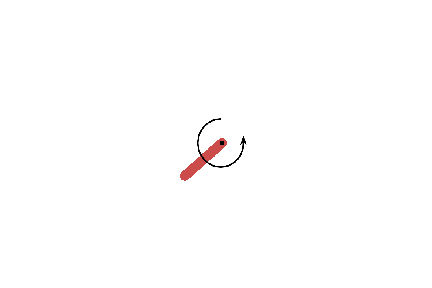
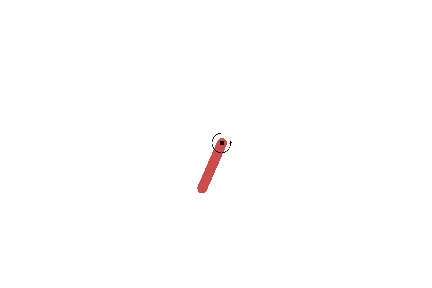
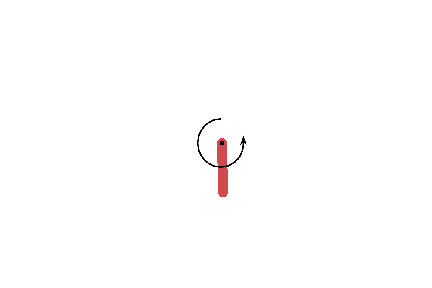
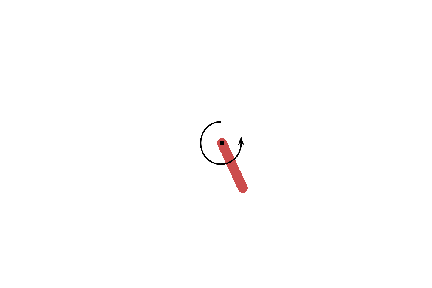
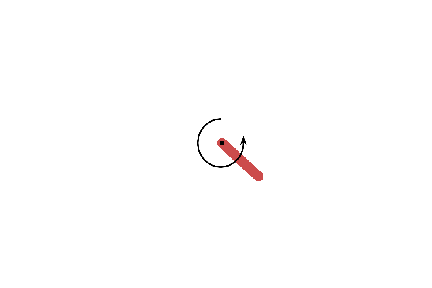
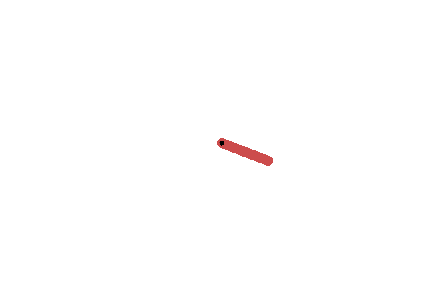
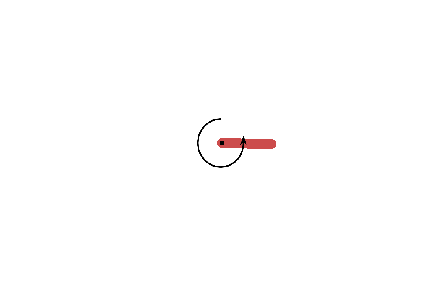
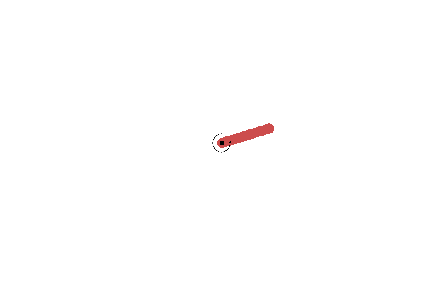
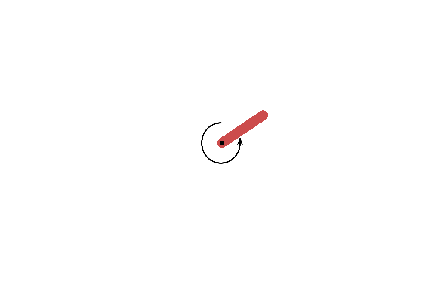
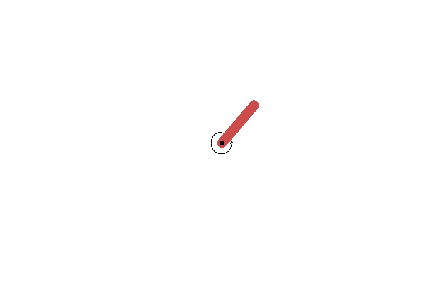
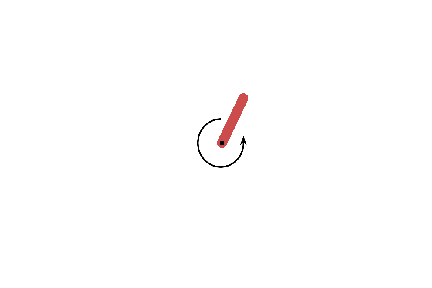
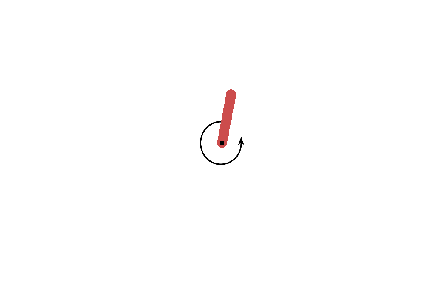
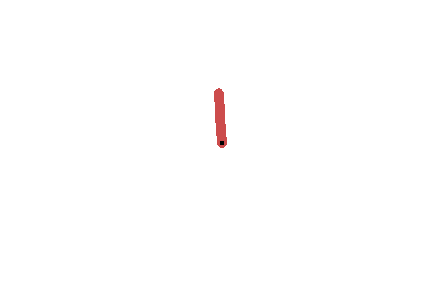
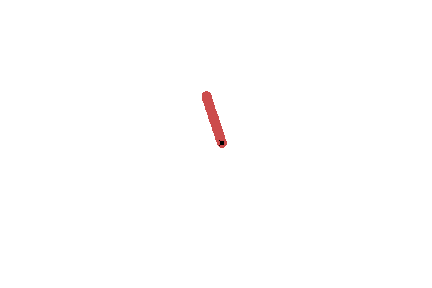
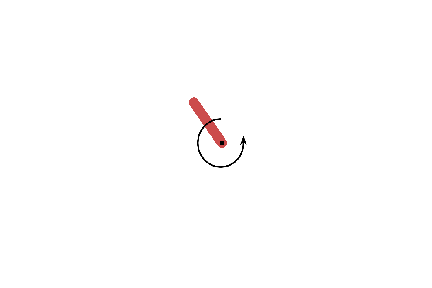
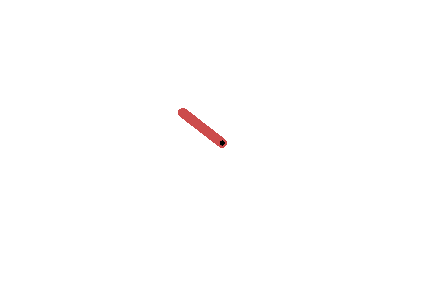
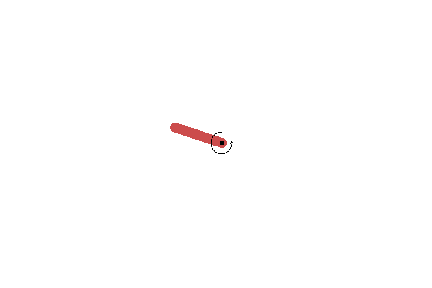
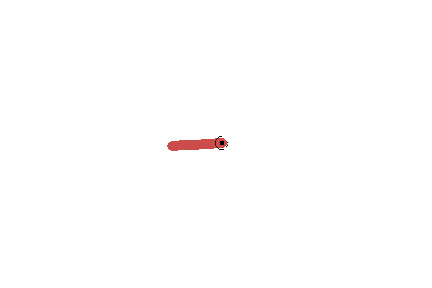
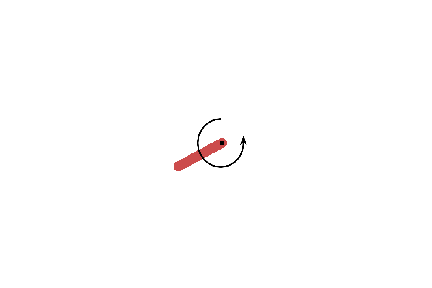
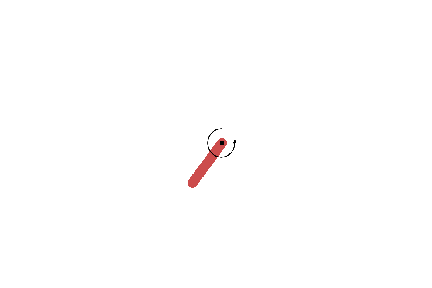
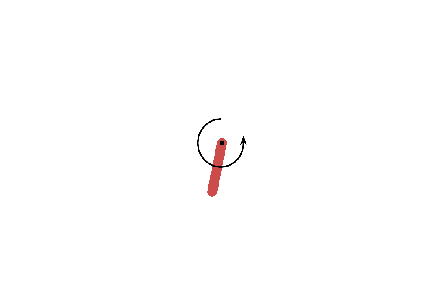
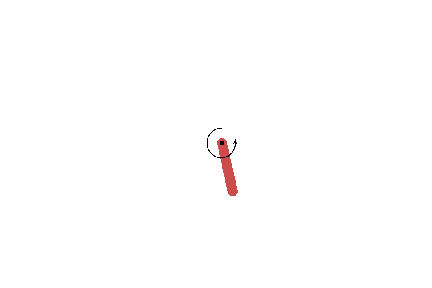
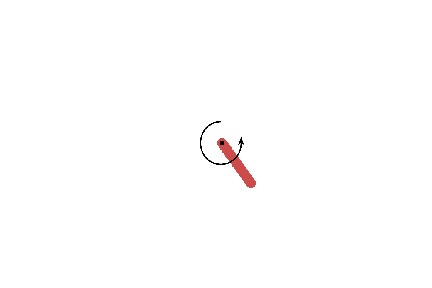
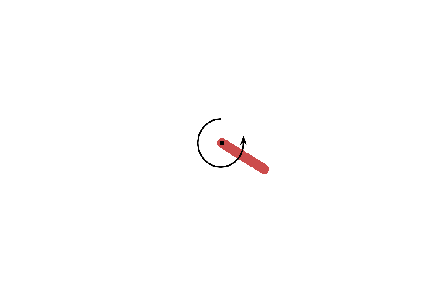
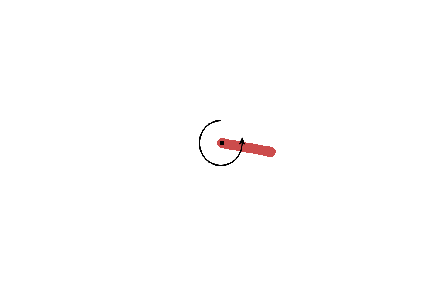
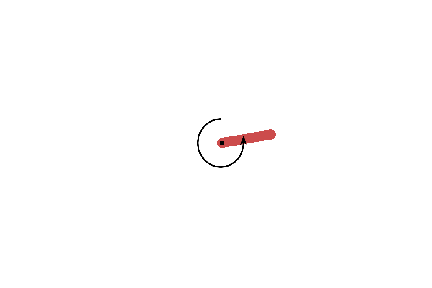
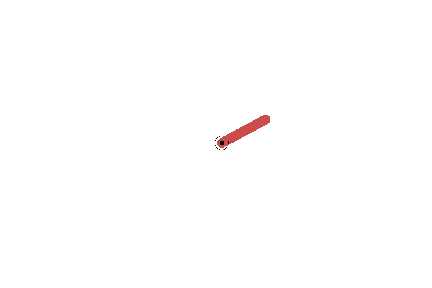
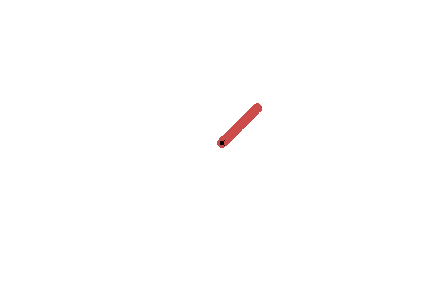
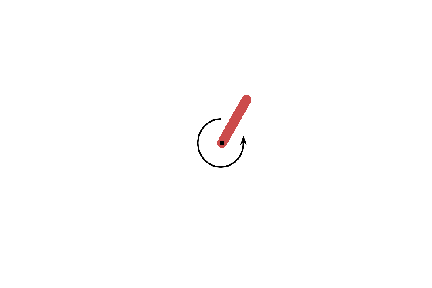
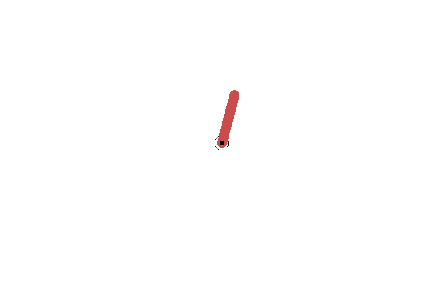
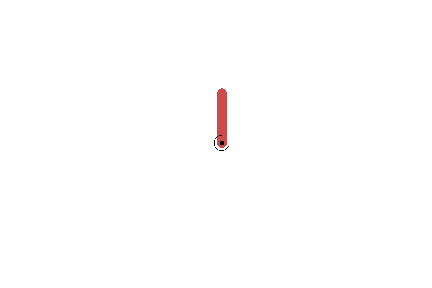
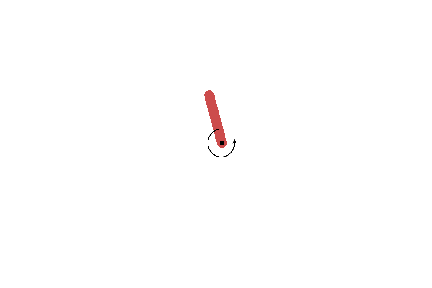
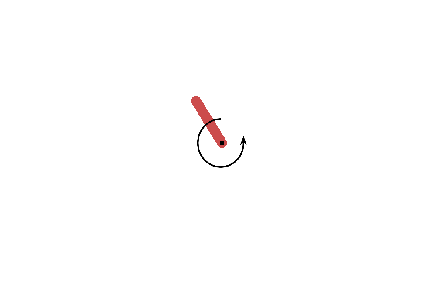
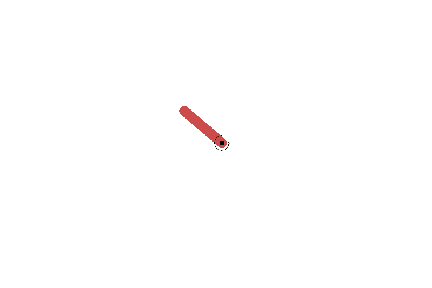
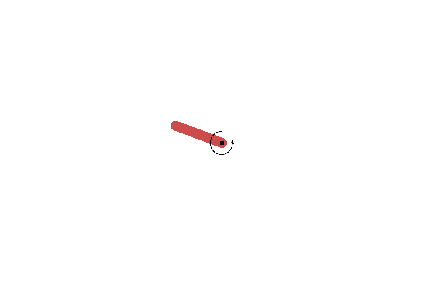
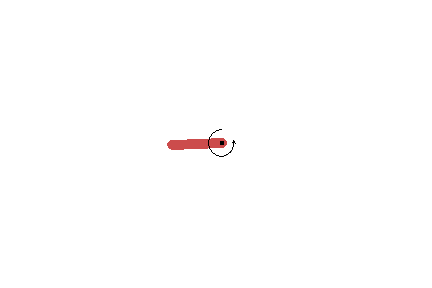
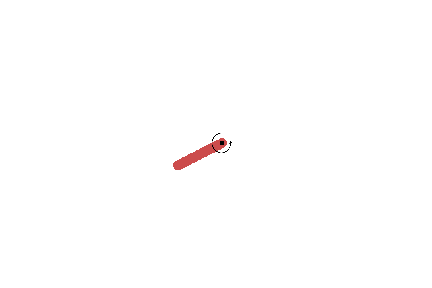
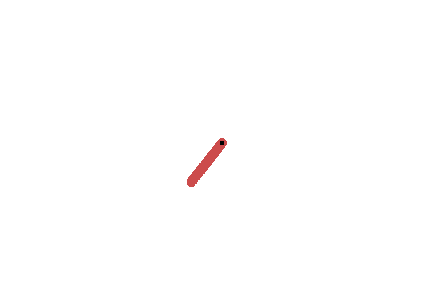
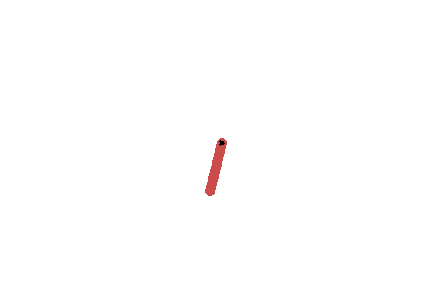
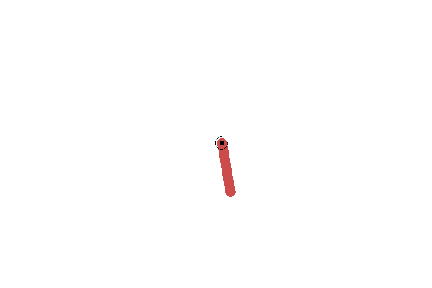
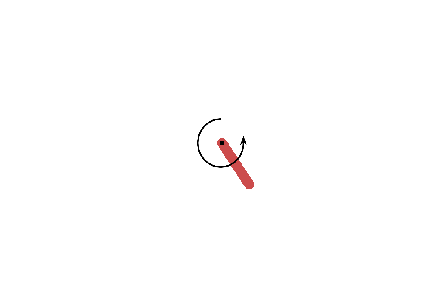
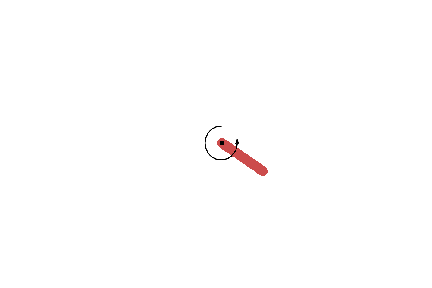
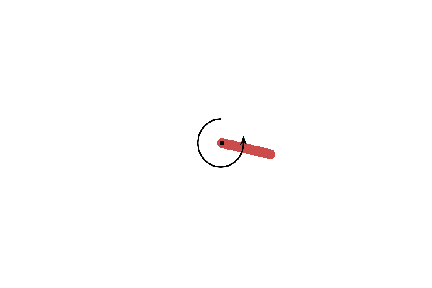
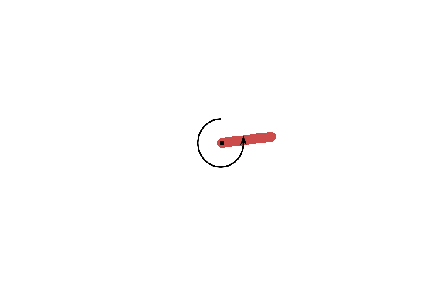
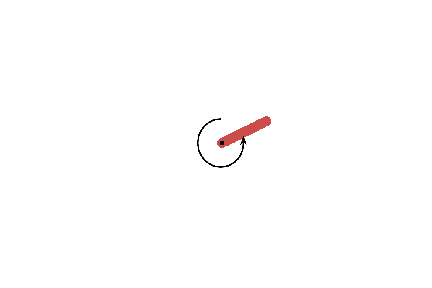
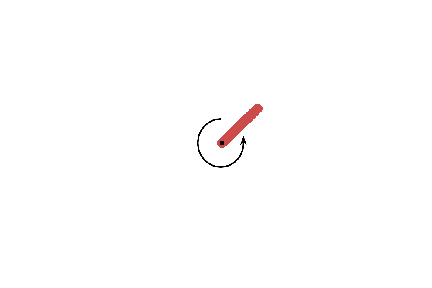
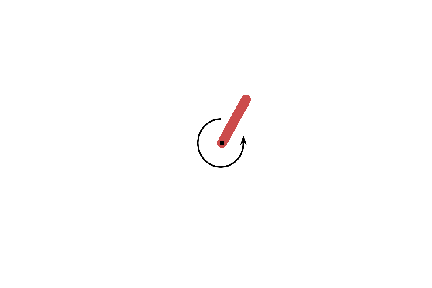
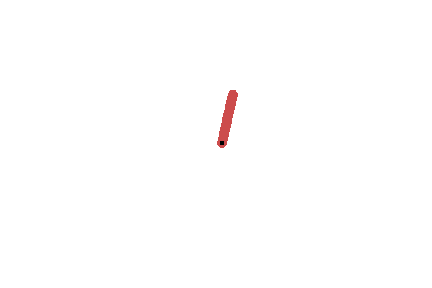
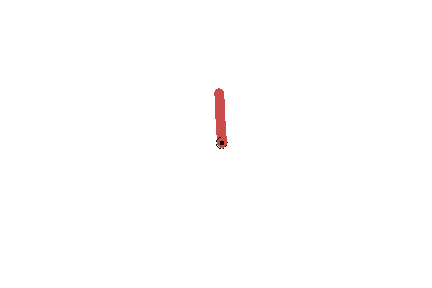
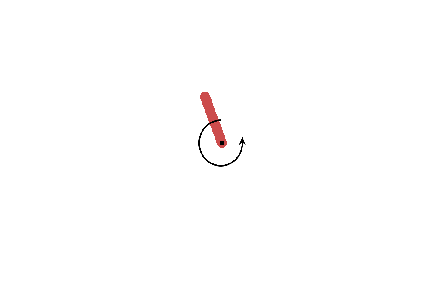
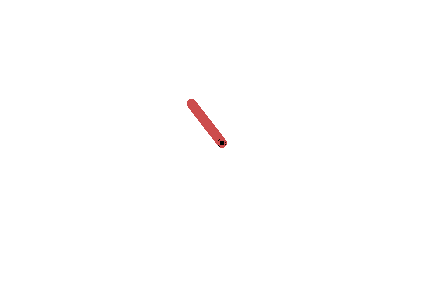
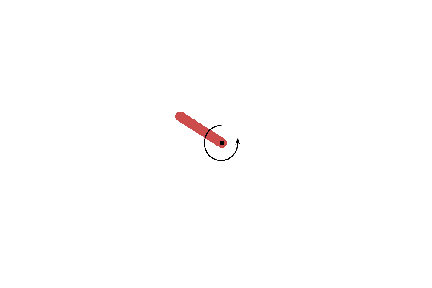
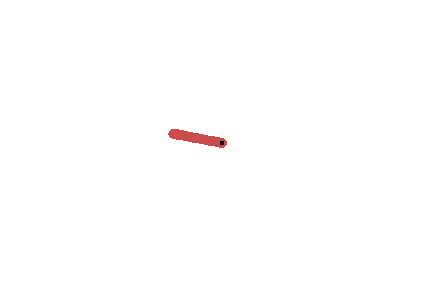
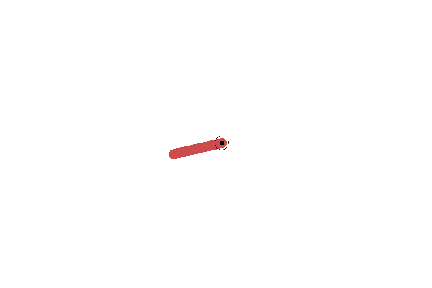
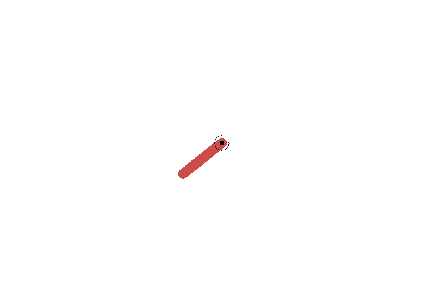
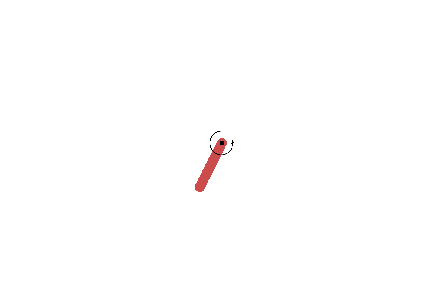
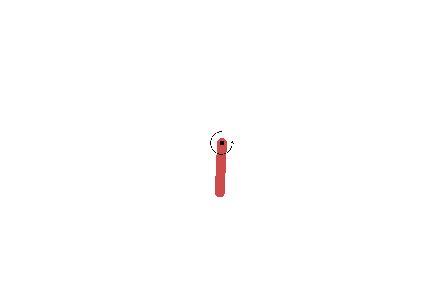
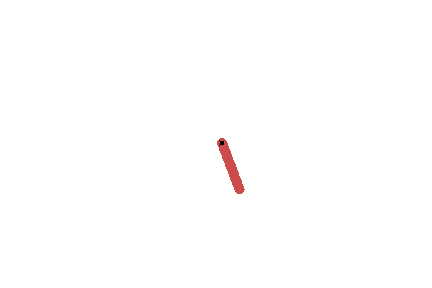
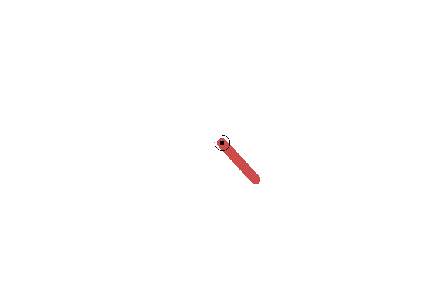
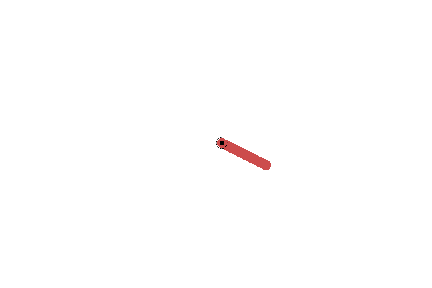
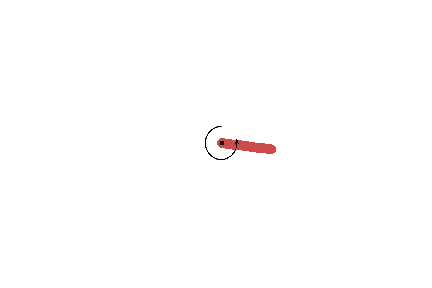
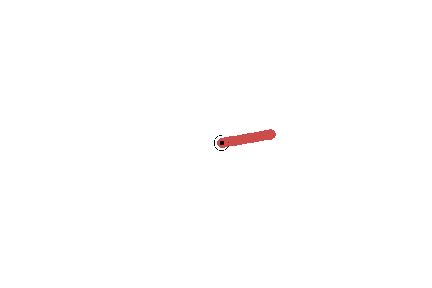
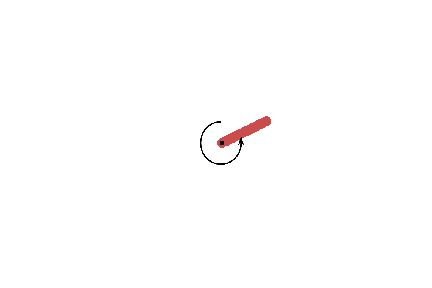
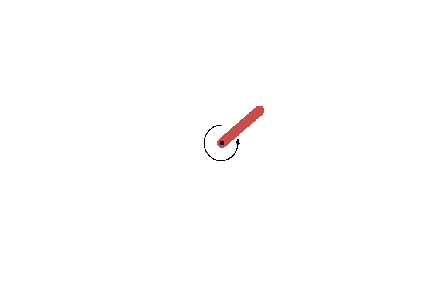
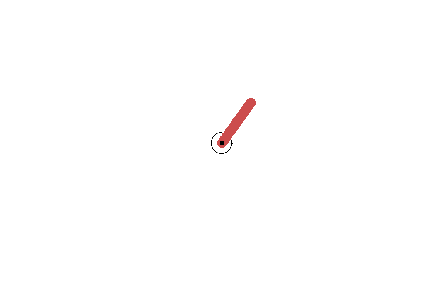
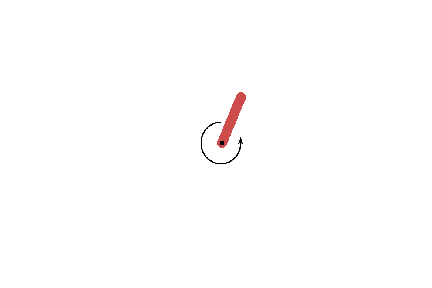
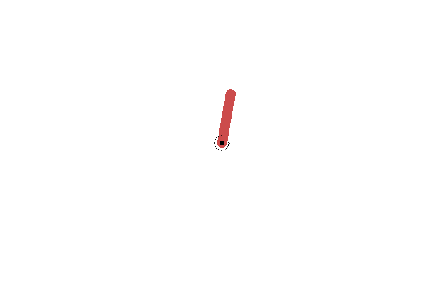
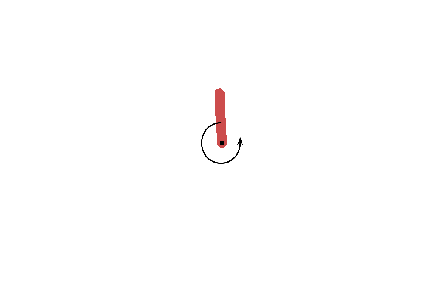
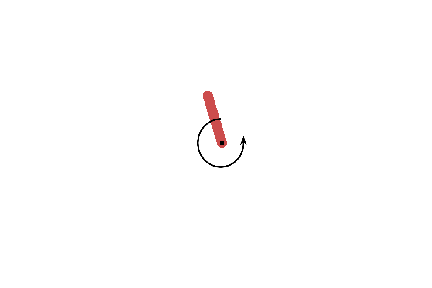
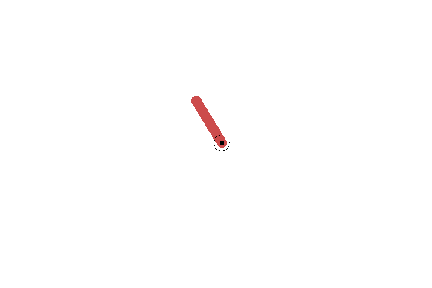
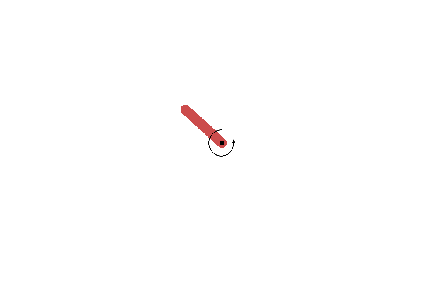
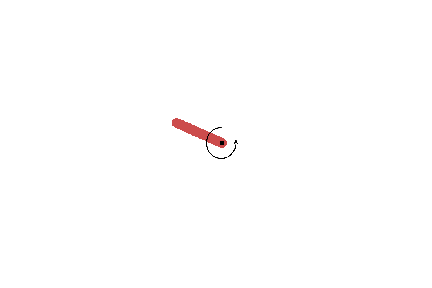
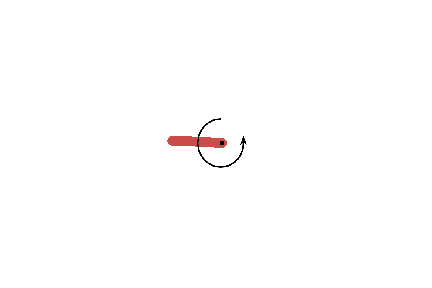
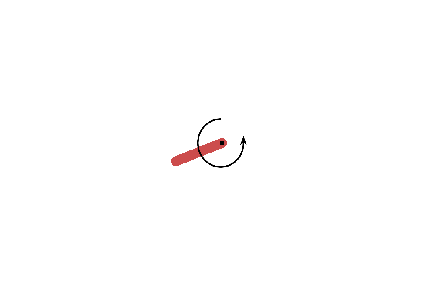
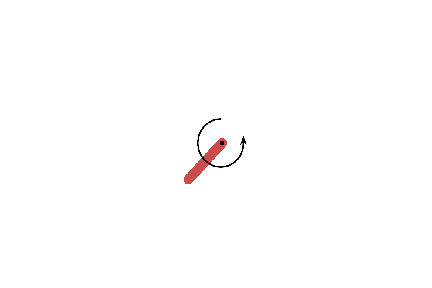
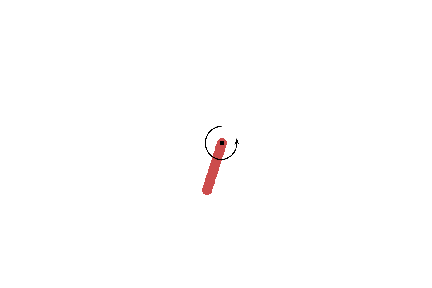
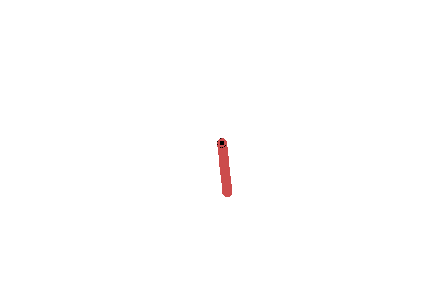
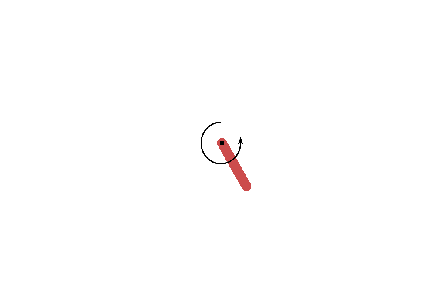
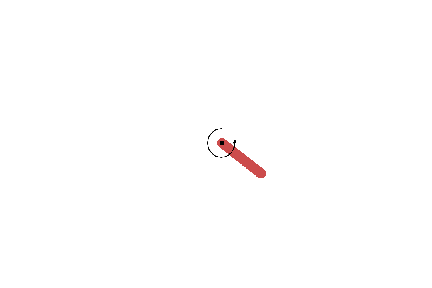
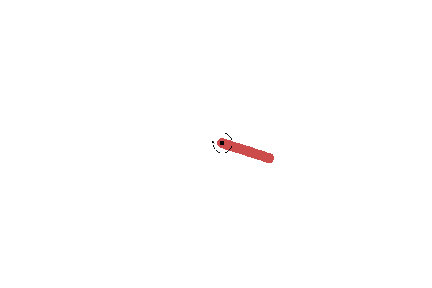
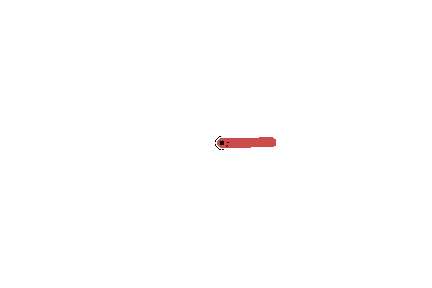
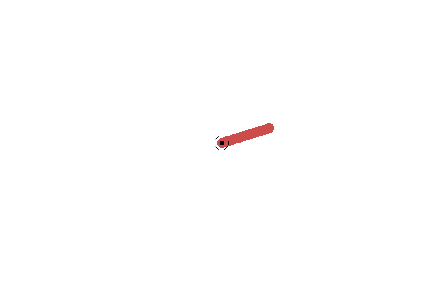
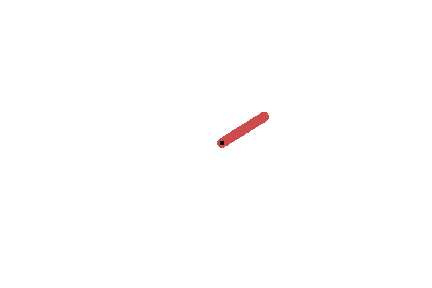
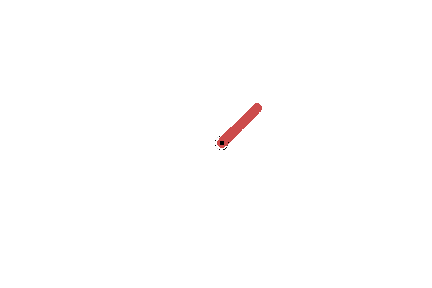
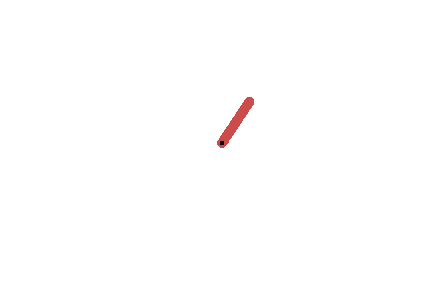
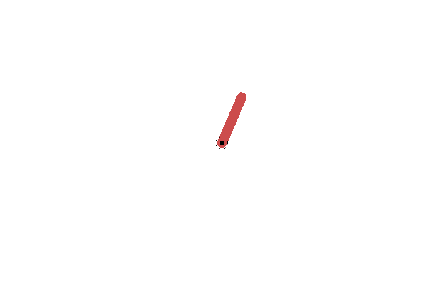
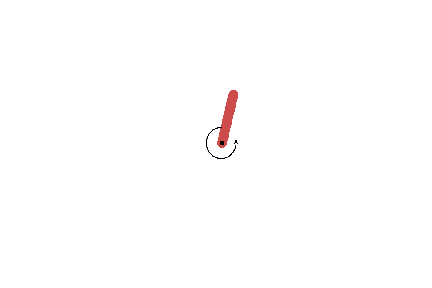
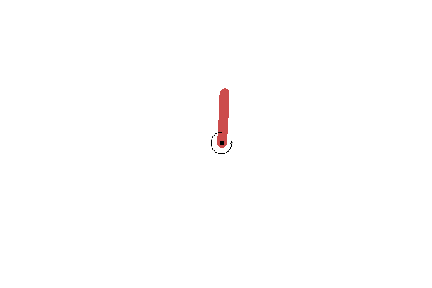
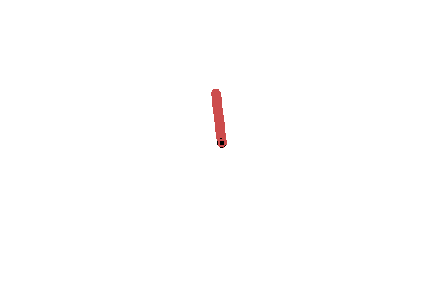
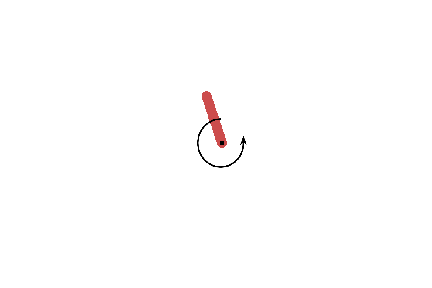
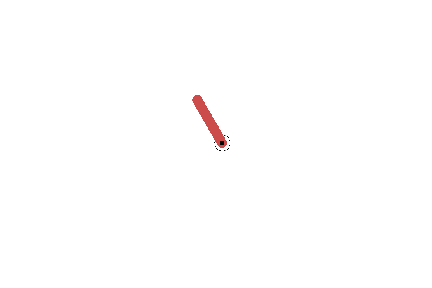
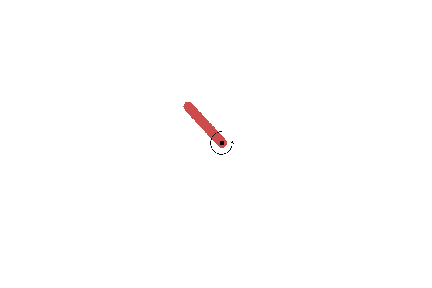
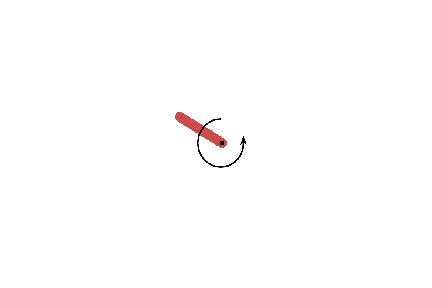
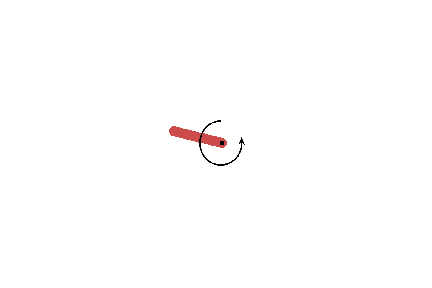
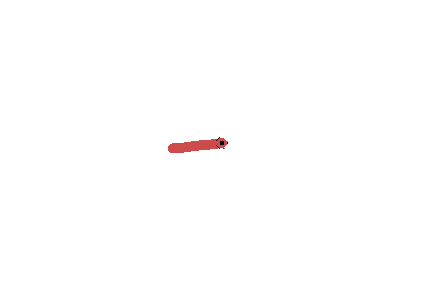
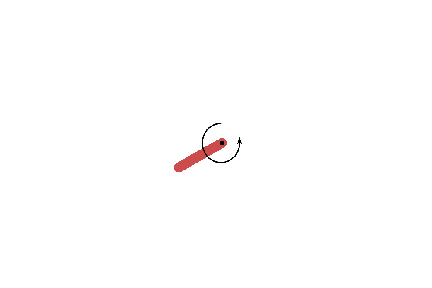
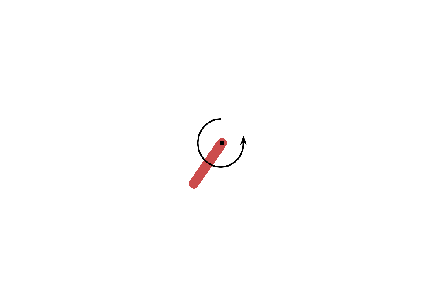
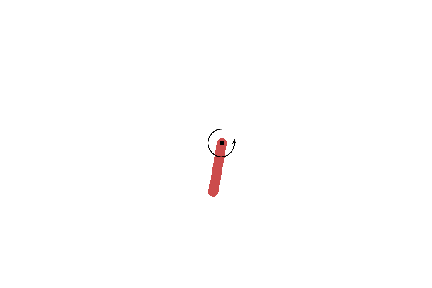
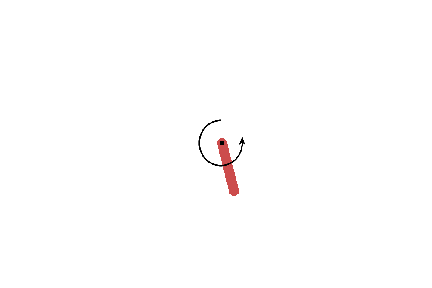
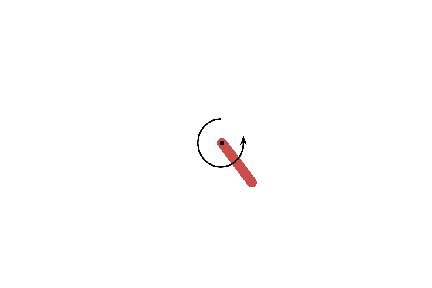
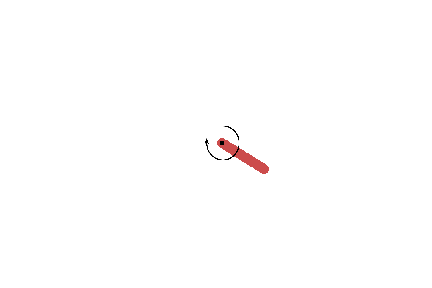
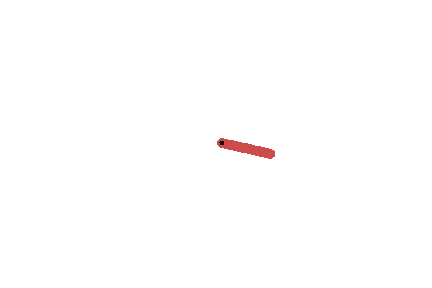
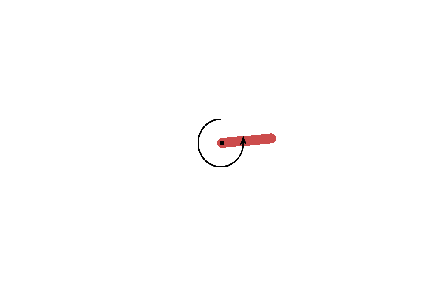
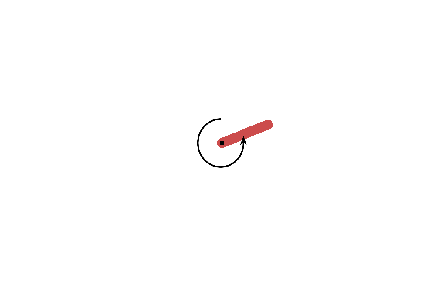
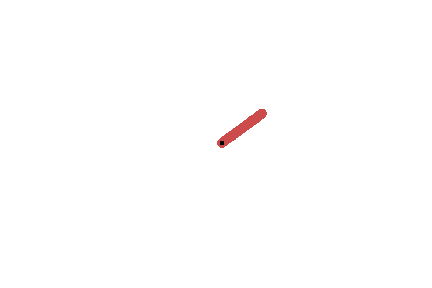
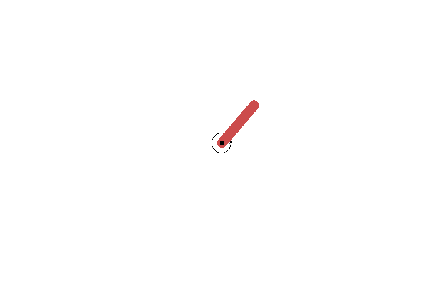
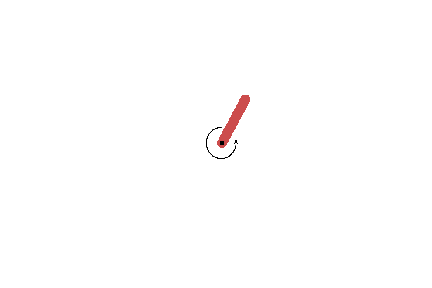
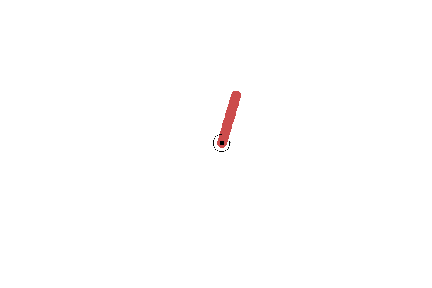
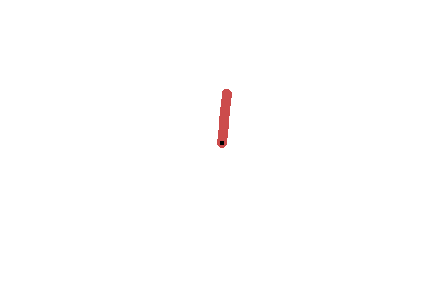
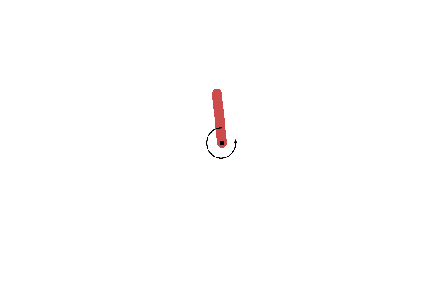
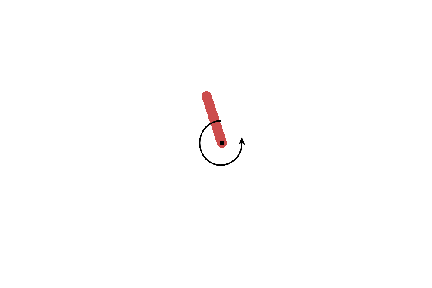
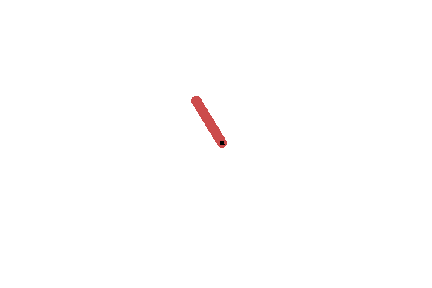
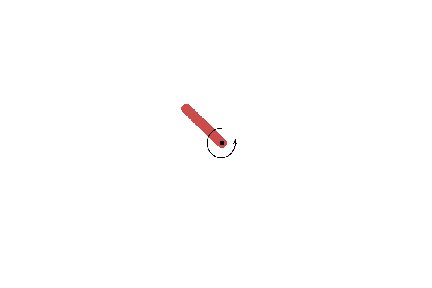
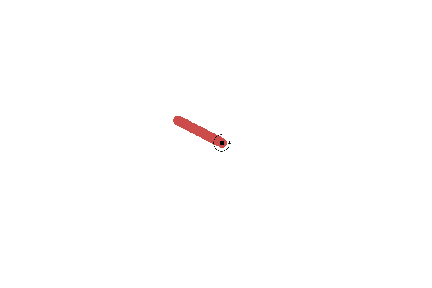
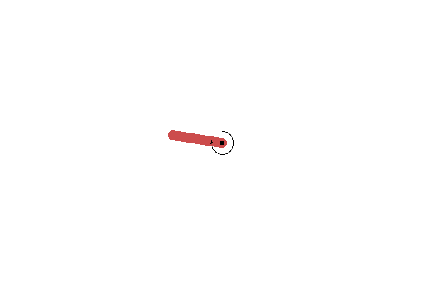
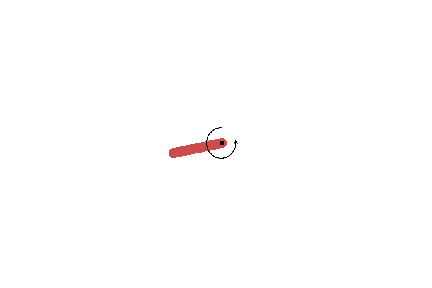
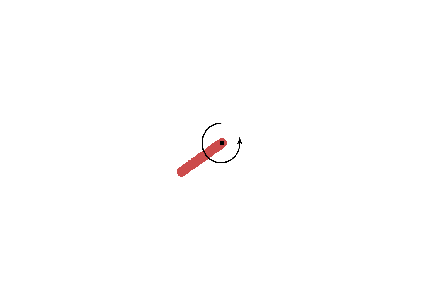
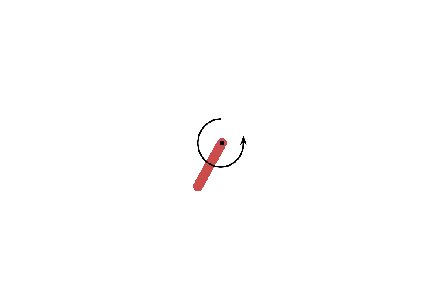
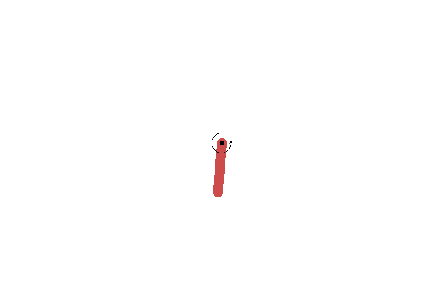
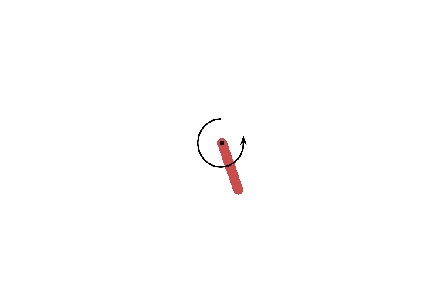
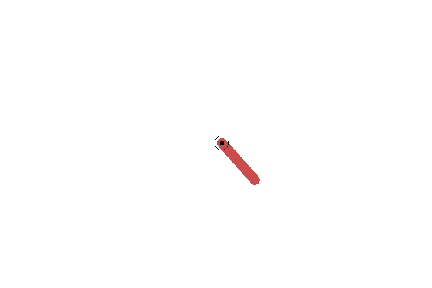
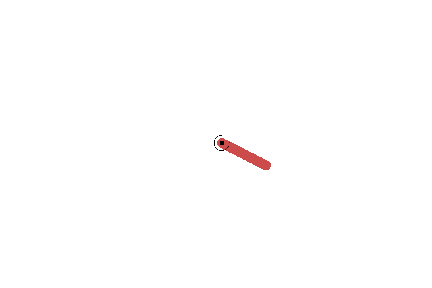
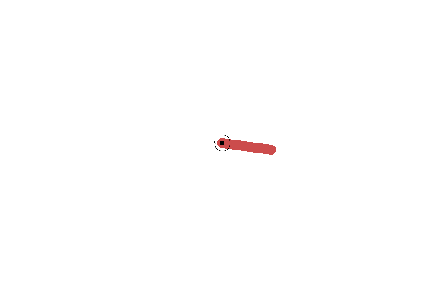
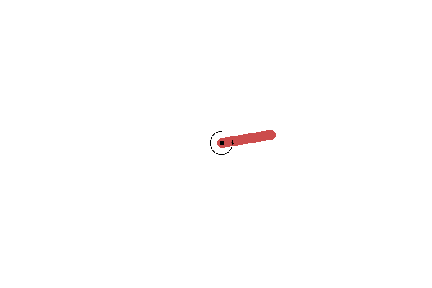
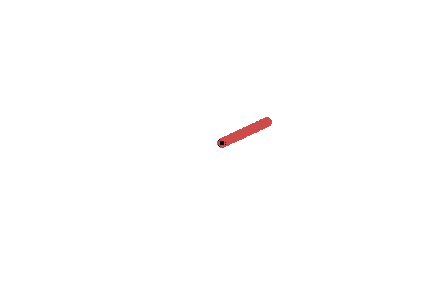
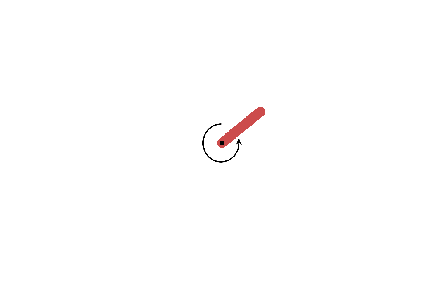
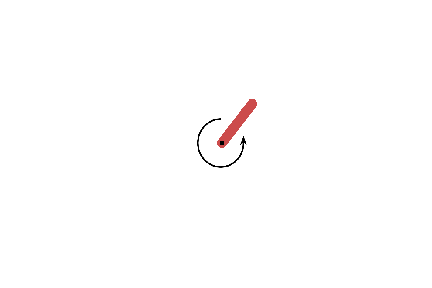
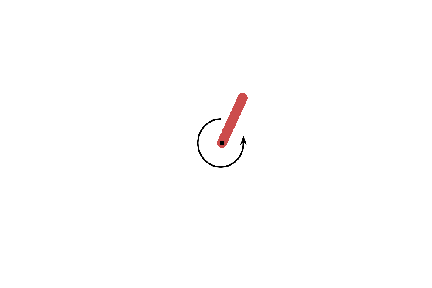
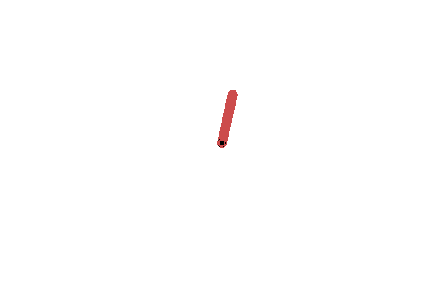
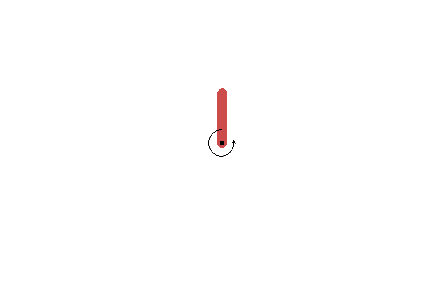
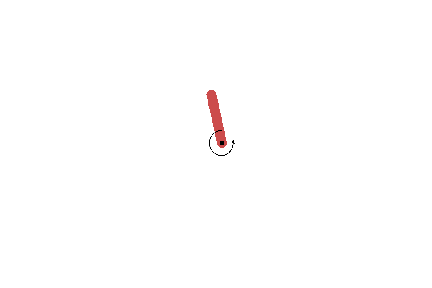
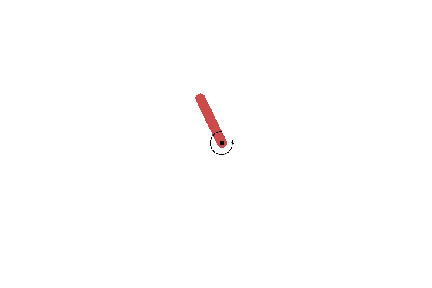
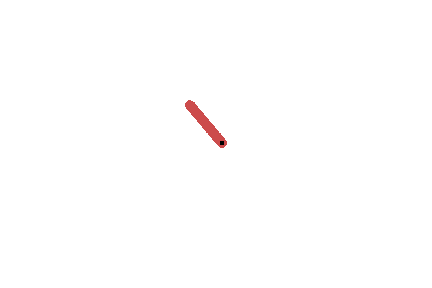
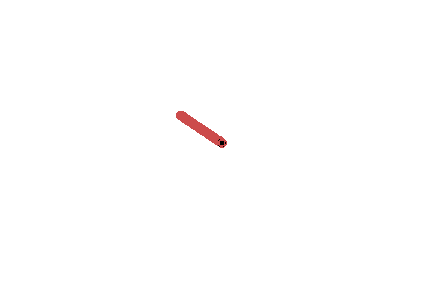
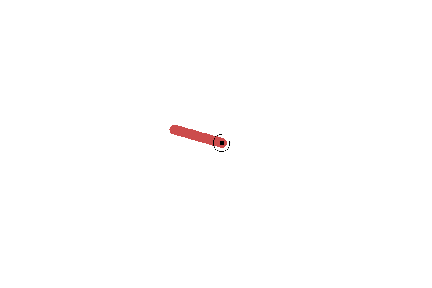
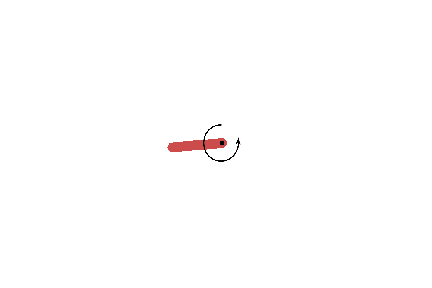
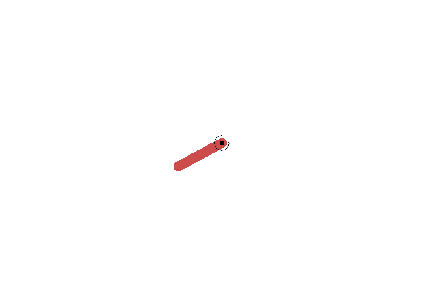
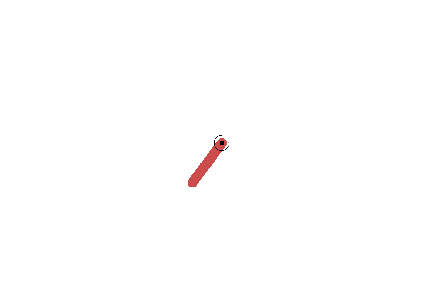
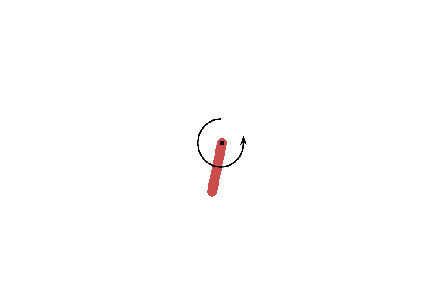
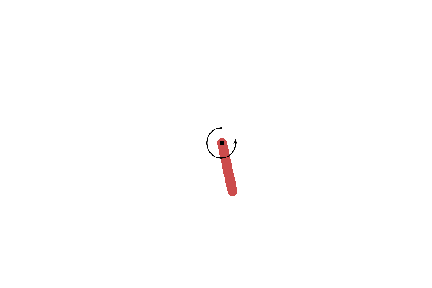
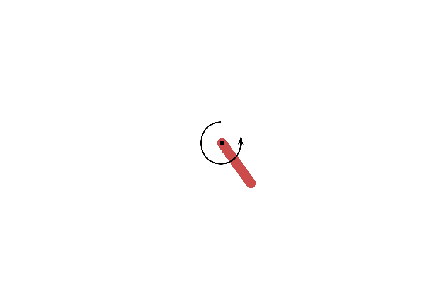
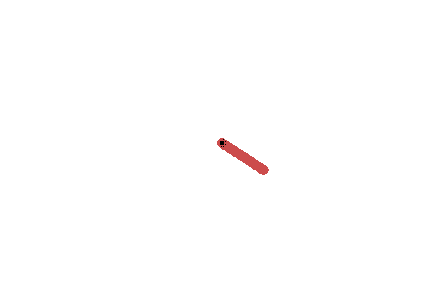
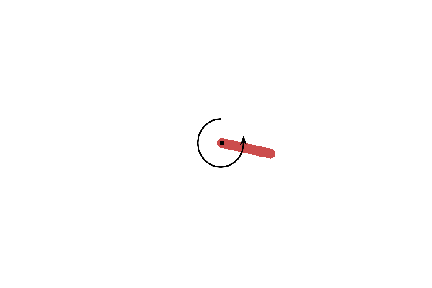
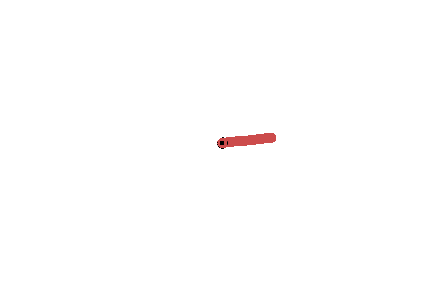
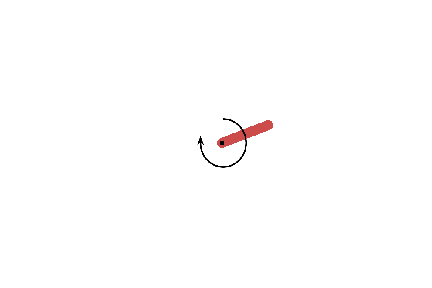
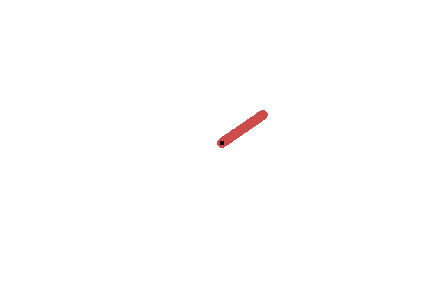
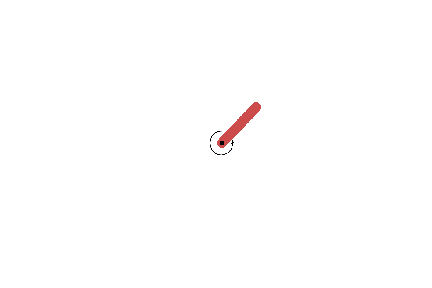
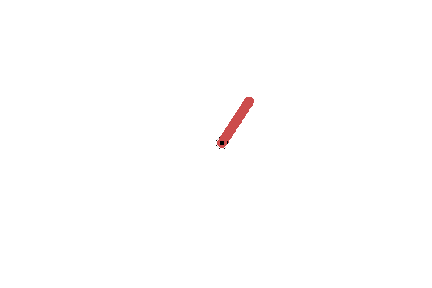
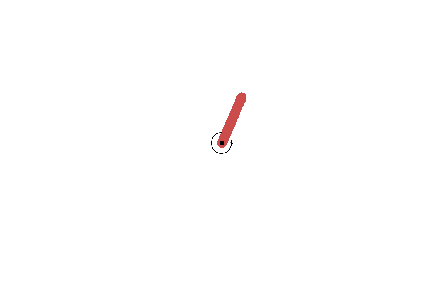
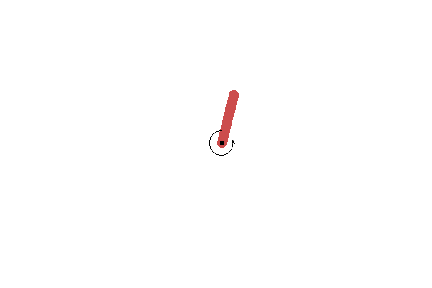
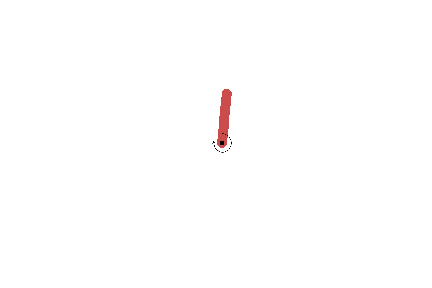
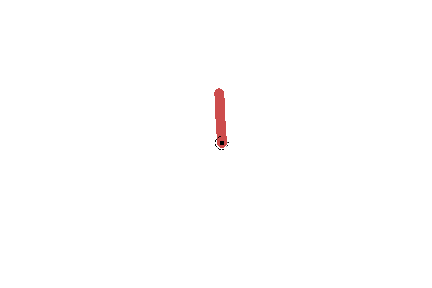
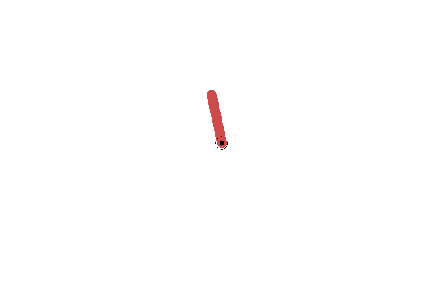
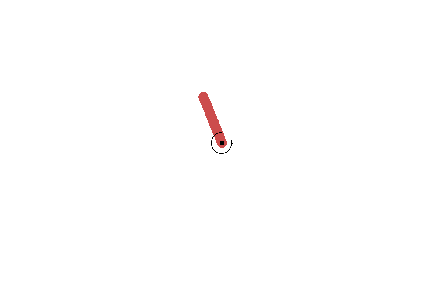
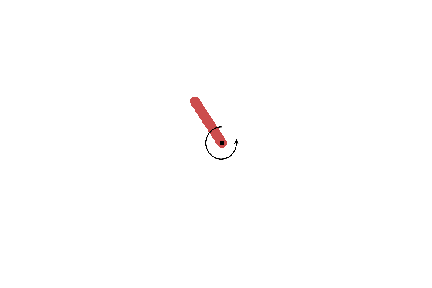
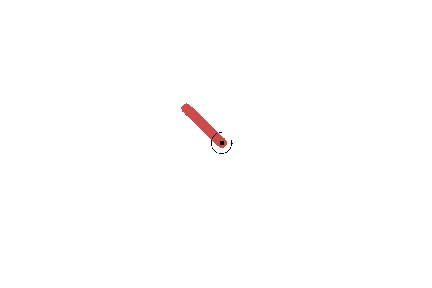
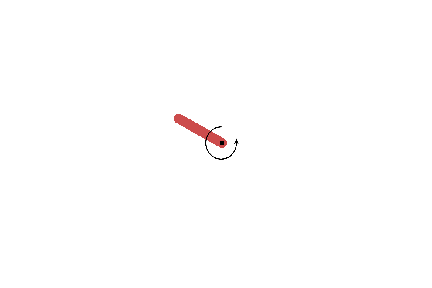
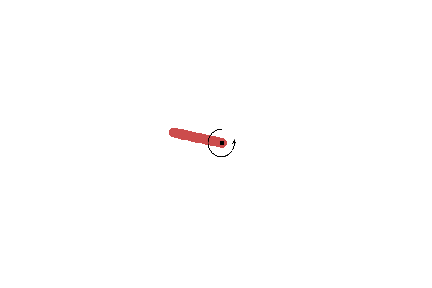
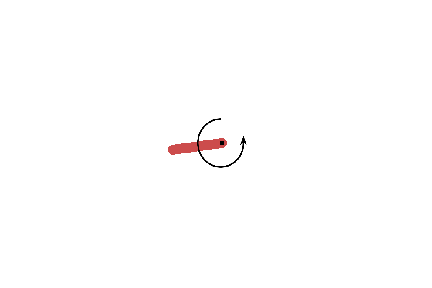
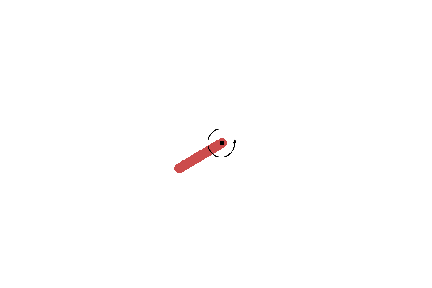
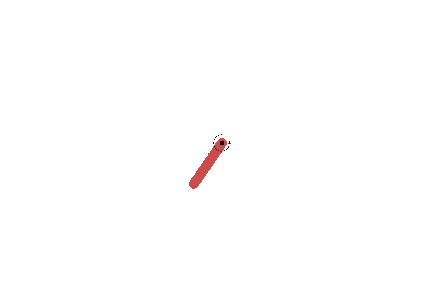

In [7]:
all_ep_r = train(env,ppo,1,render=True)

### 3.2 perform the training!

At epoch 0 - Ep. Reward -1328
At epoch 100 - Ep. Reward -887
At epoch 200 - Ep. Reward -258
At epoch 300 - Ep. Reward -559
At epoch 400 - Ep. Reward -402
At epoch 500 - Ep. Reward 0
At epoch 600 - Ep. Reward -1
At epoch 700 - Ep. Reward -1239
At epoch 800 - Ep. Reward -296
At epoch 900 - Ep. Reward 0



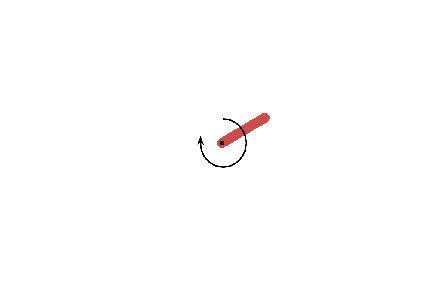
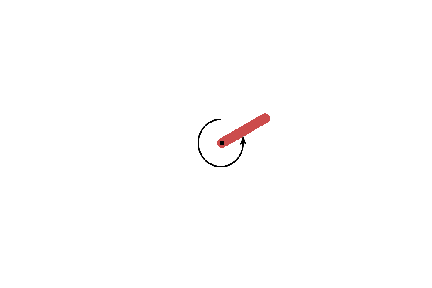
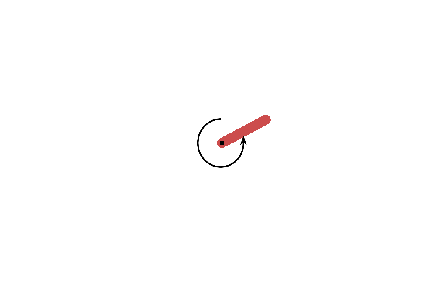
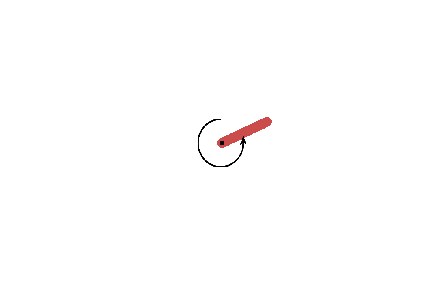
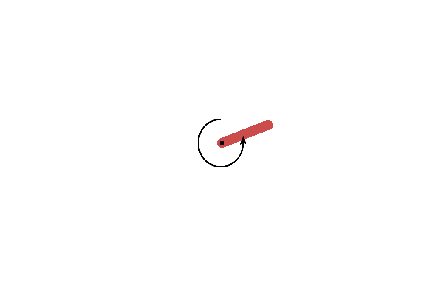
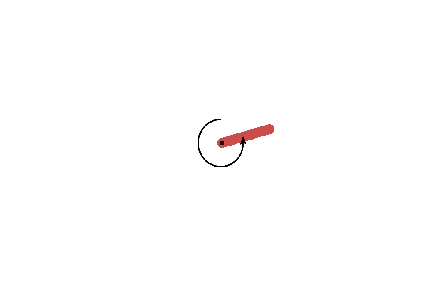
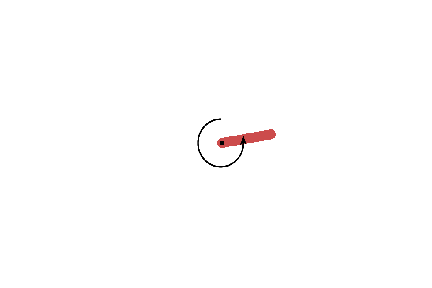
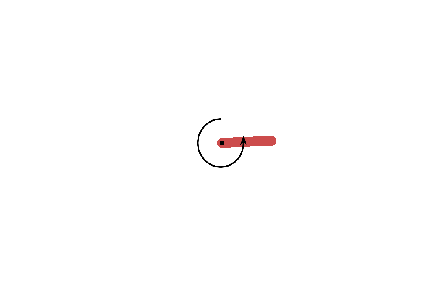
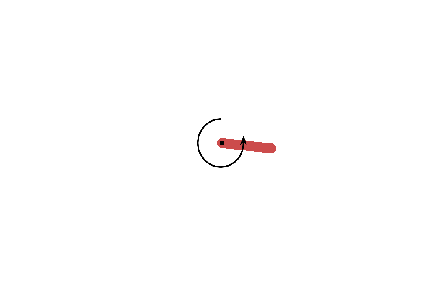
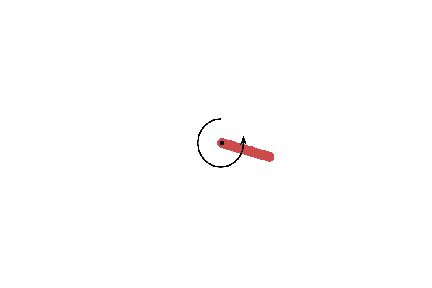
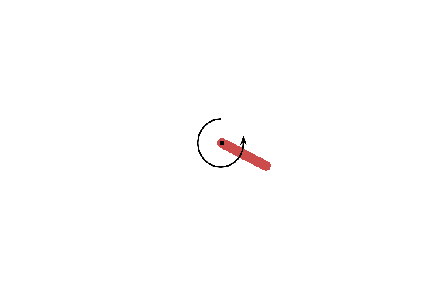
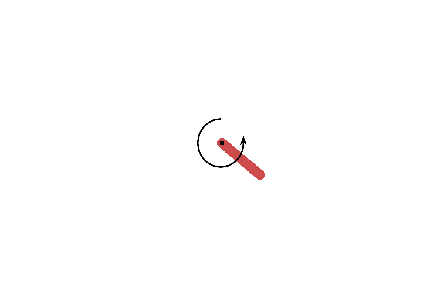
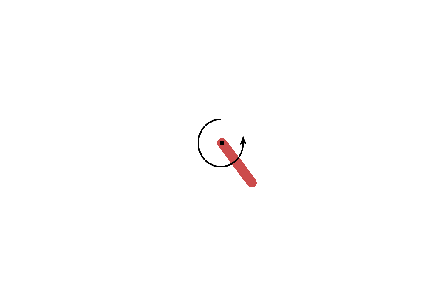
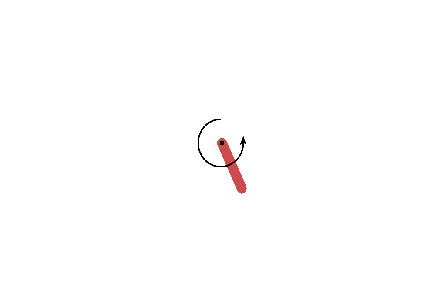
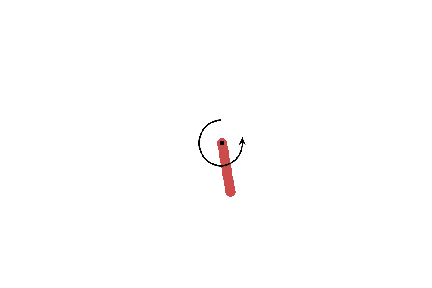
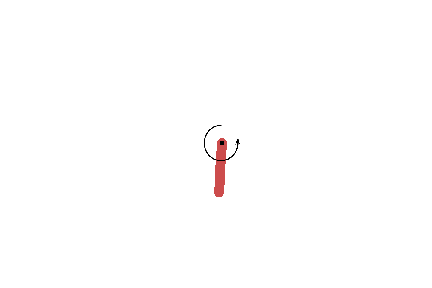
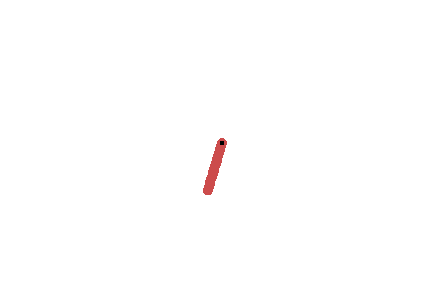
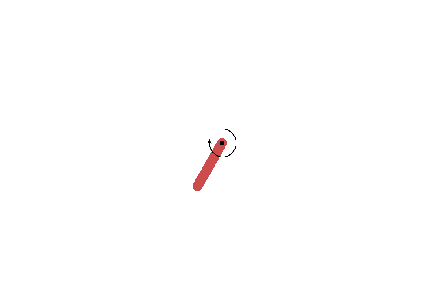
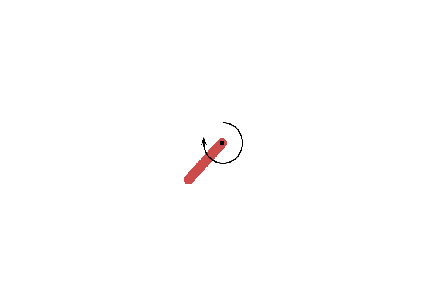
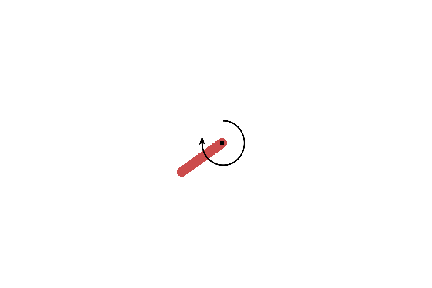
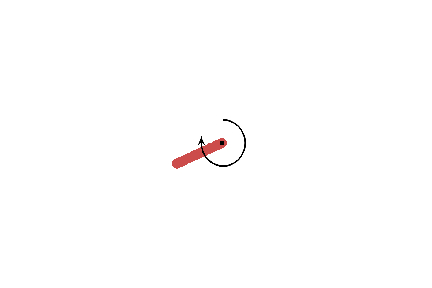
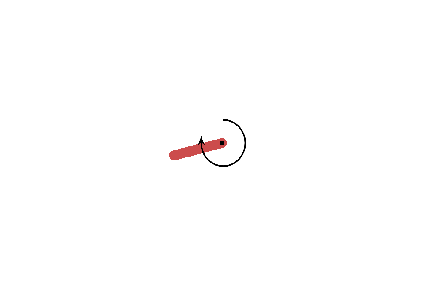
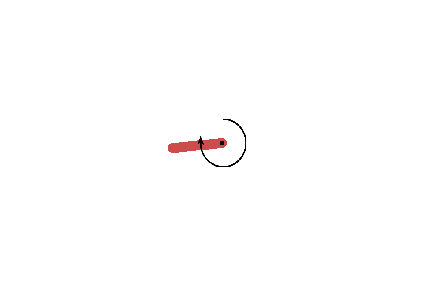
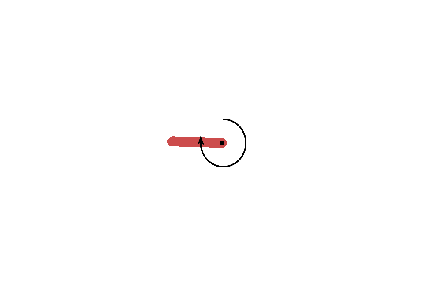
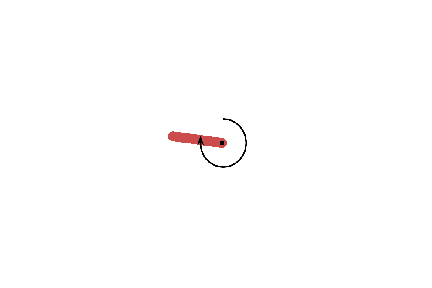
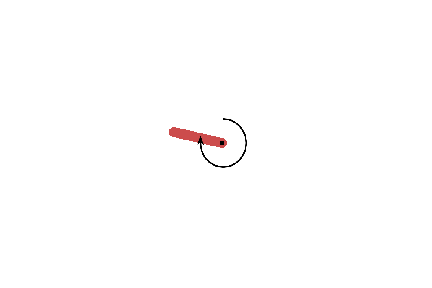
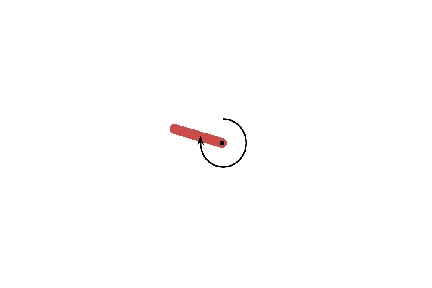
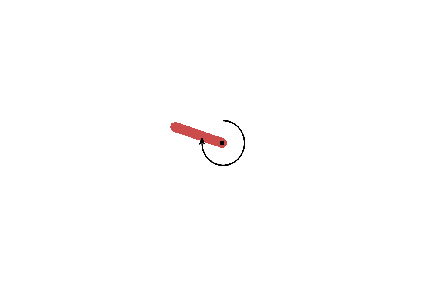
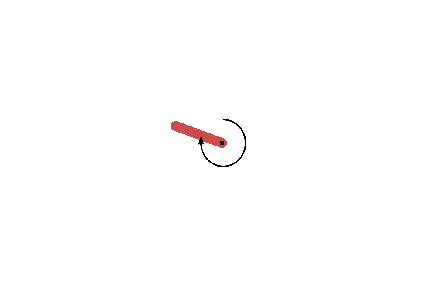
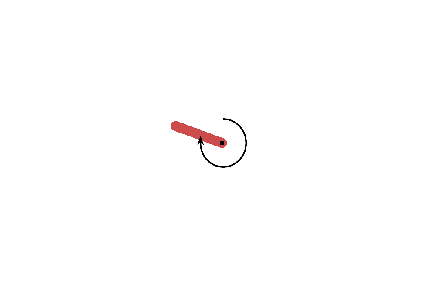
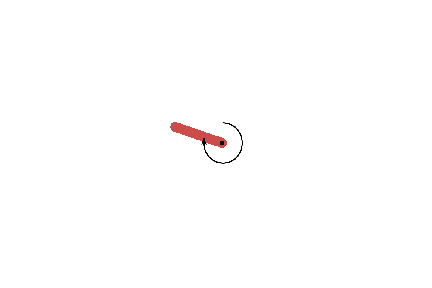
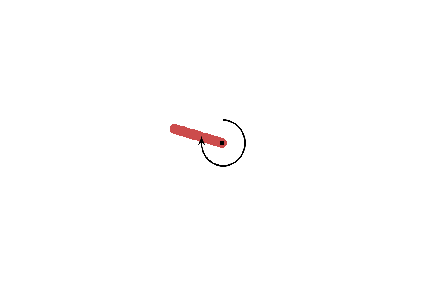
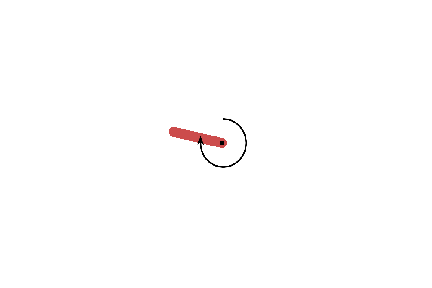
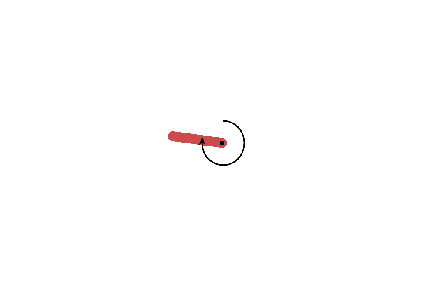
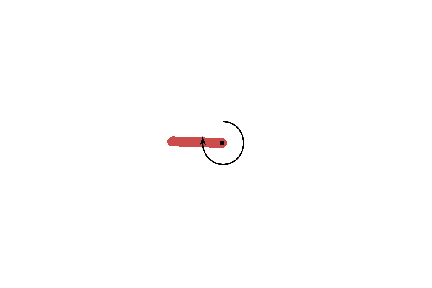
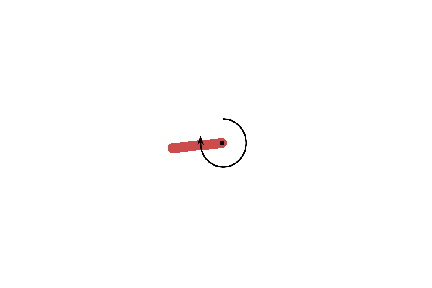
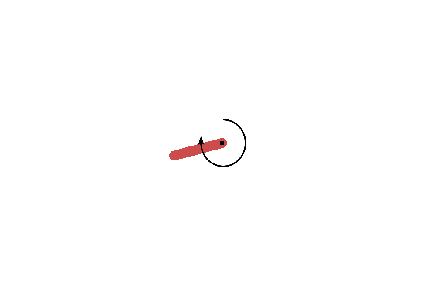
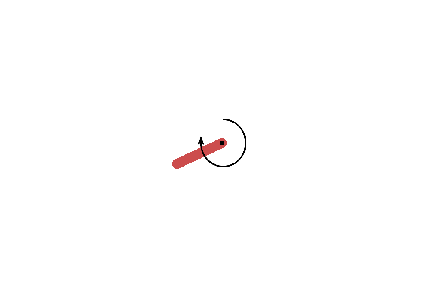
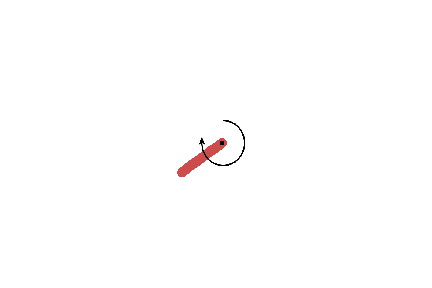
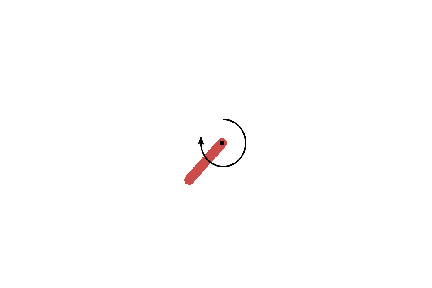
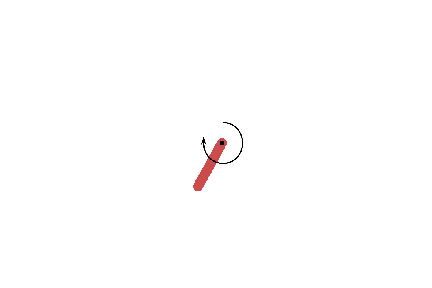
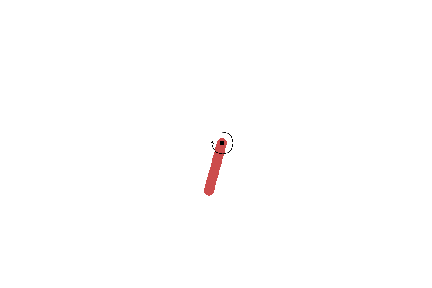
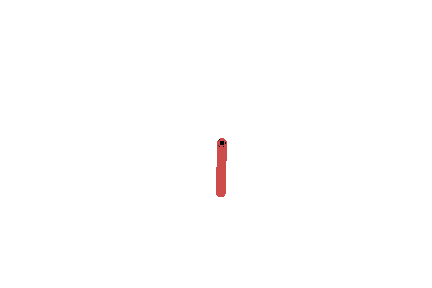
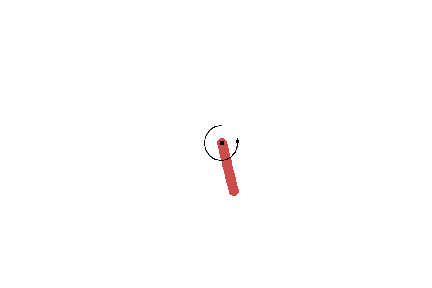
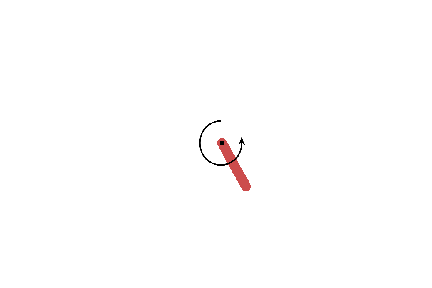
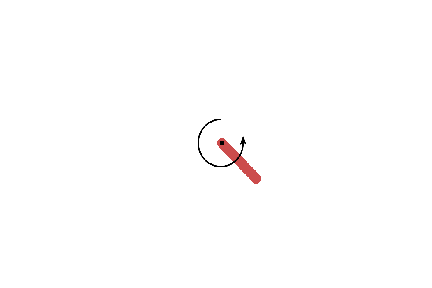
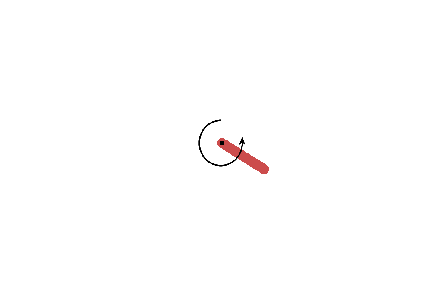
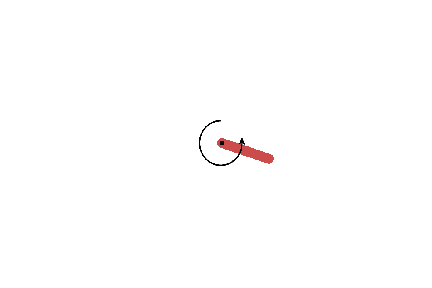
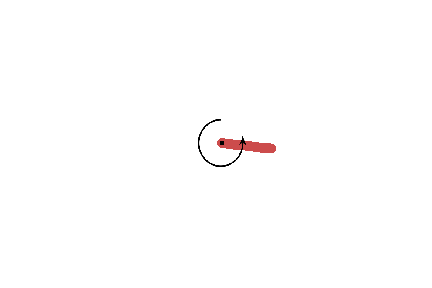
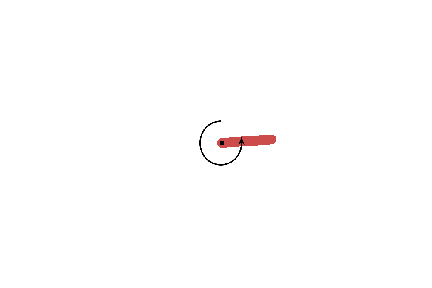
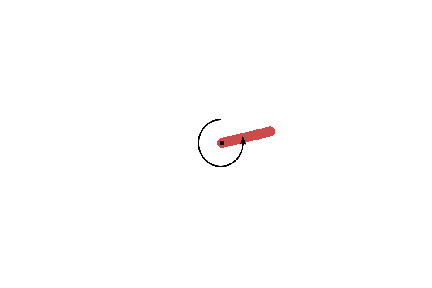
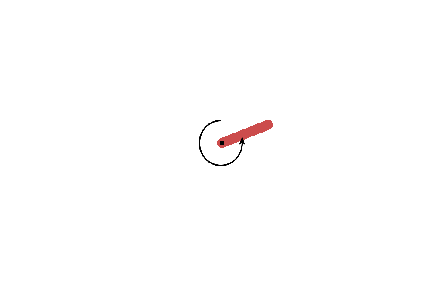
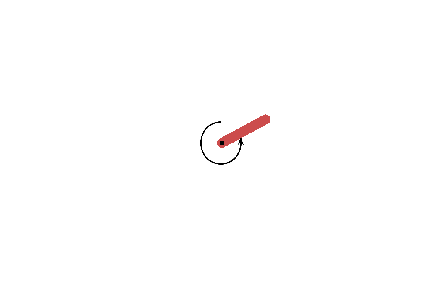
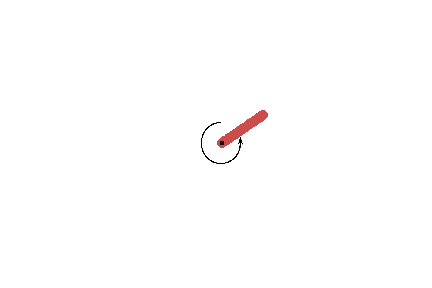
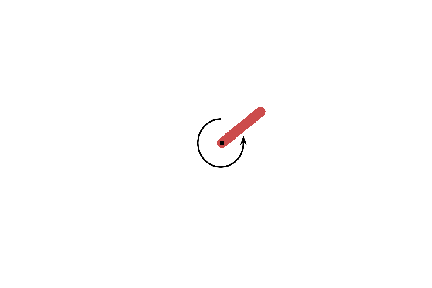
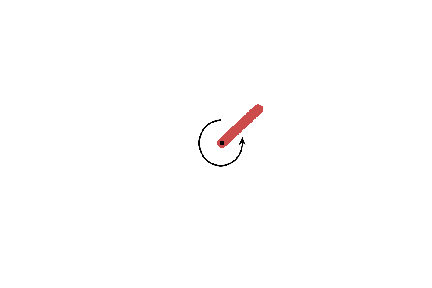
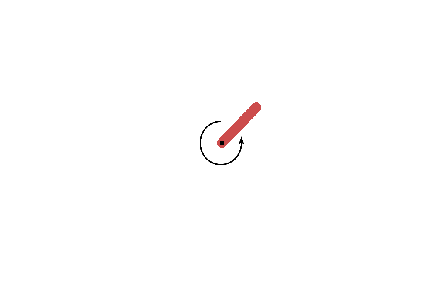
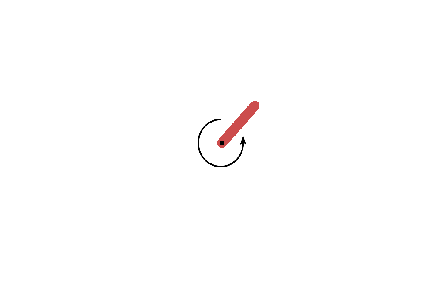
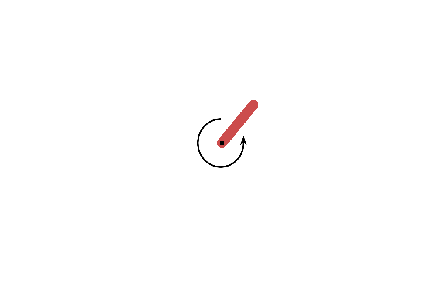
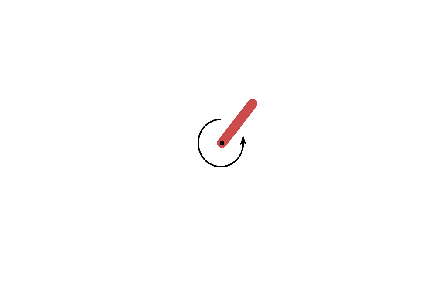
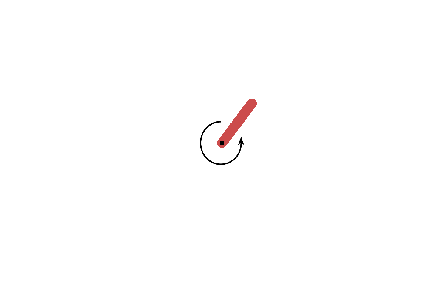
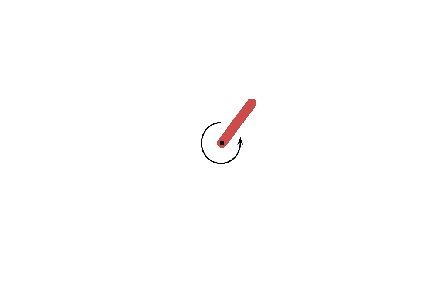
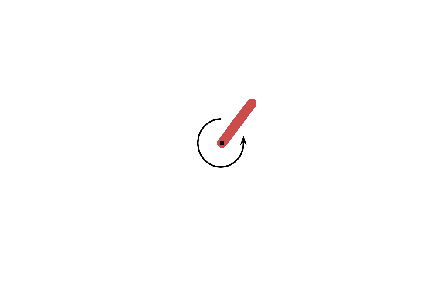
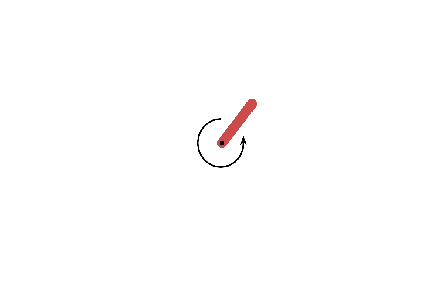
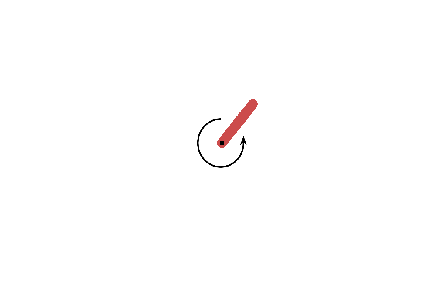
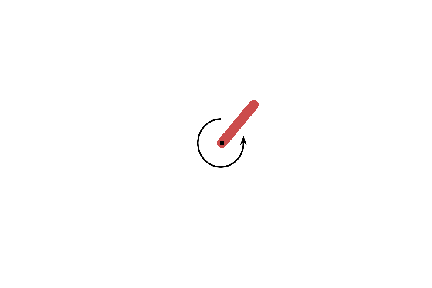
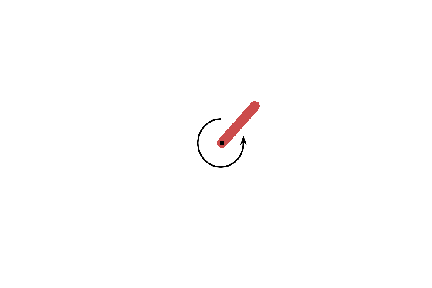
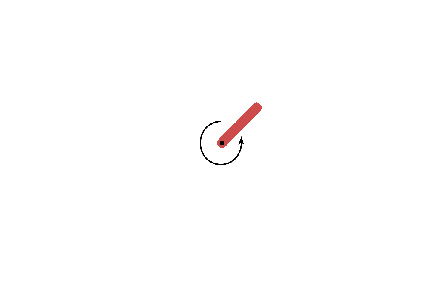
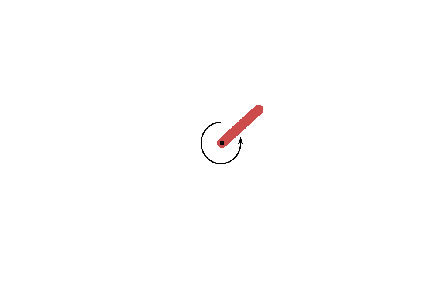
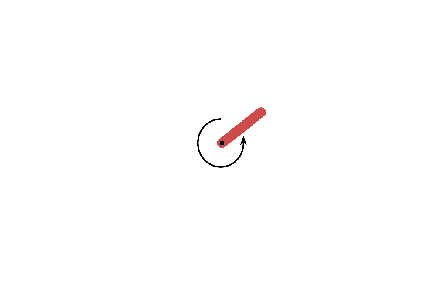
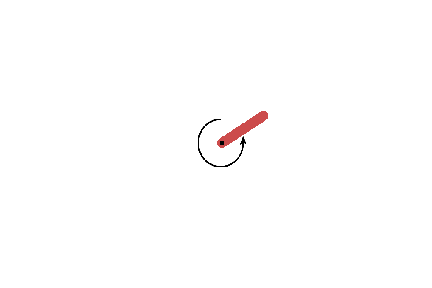
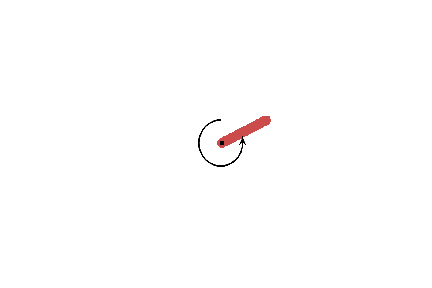
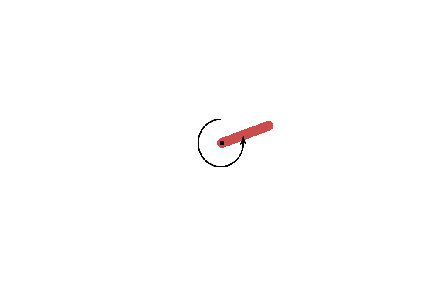
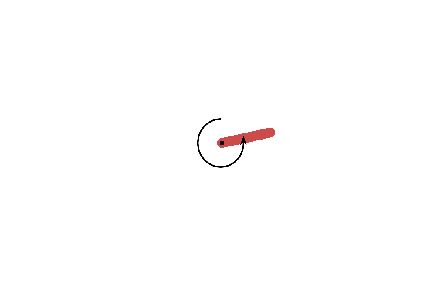
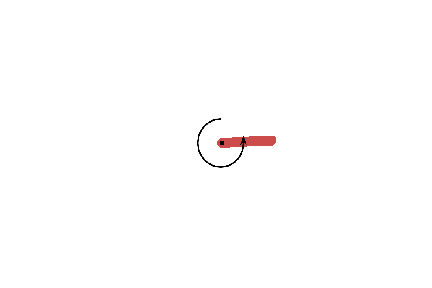
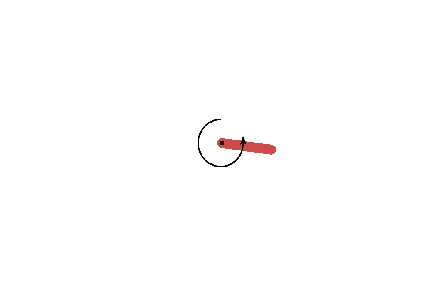
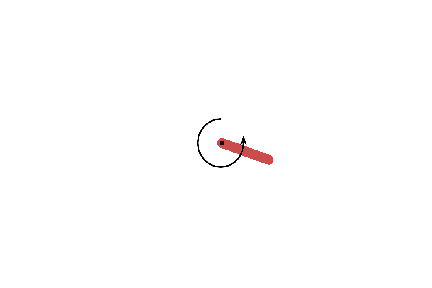
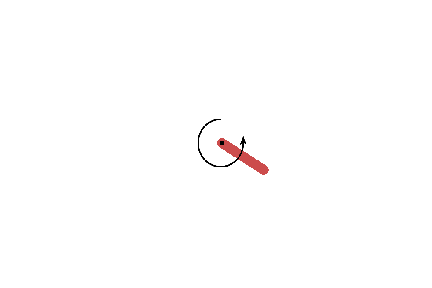
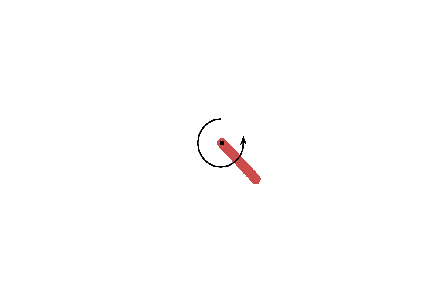
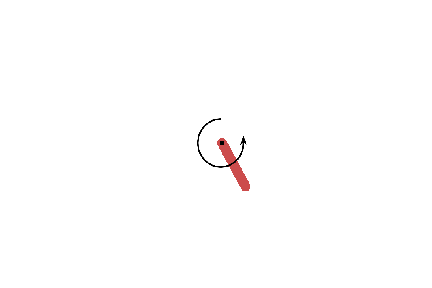
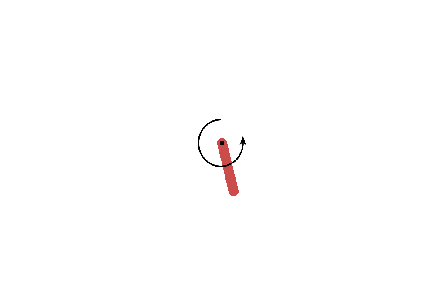
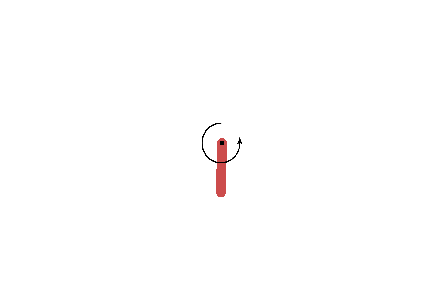
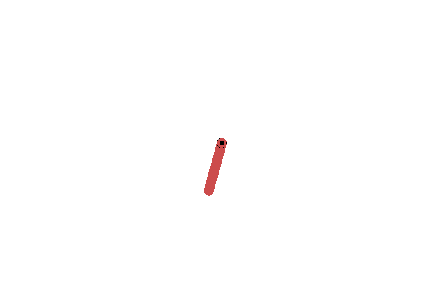
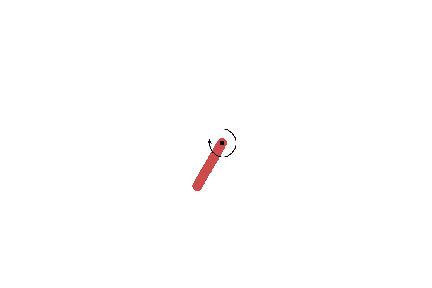
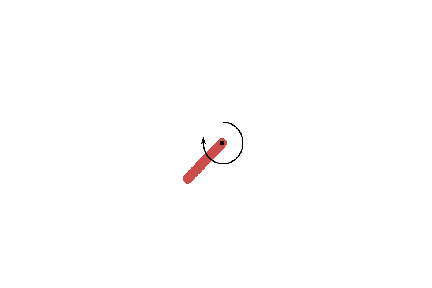
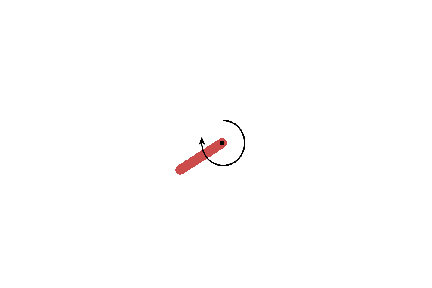
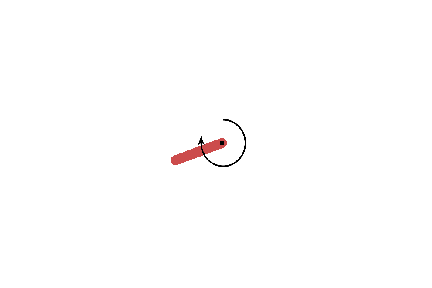
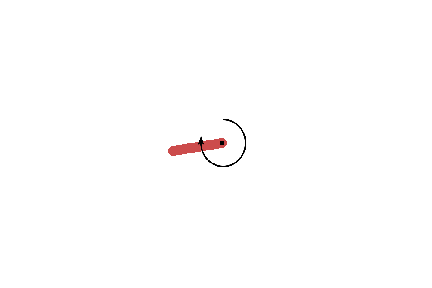
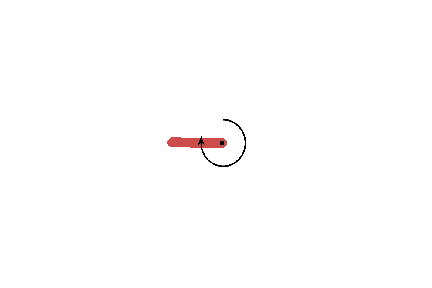
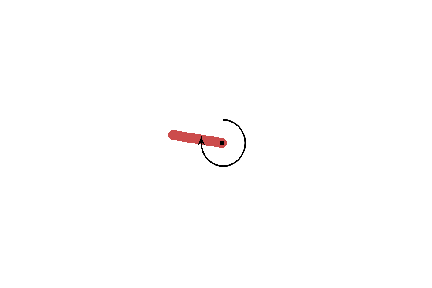
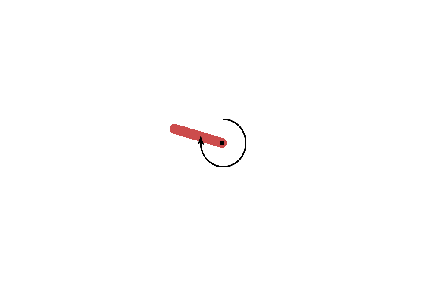
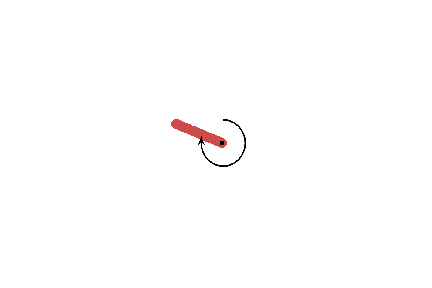
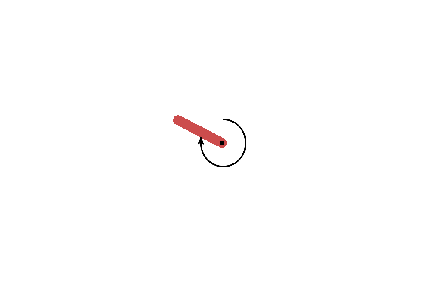
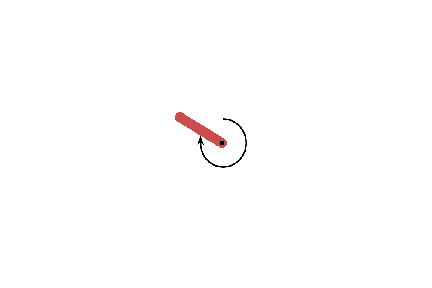
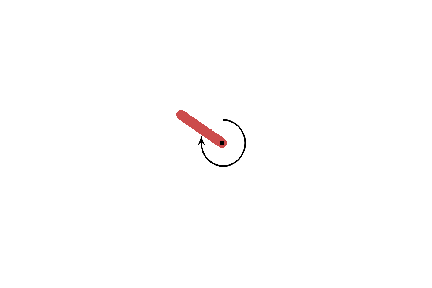
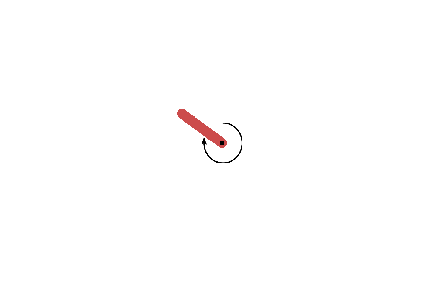
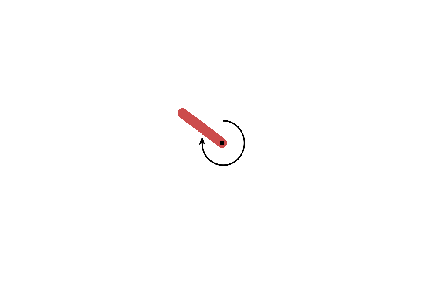
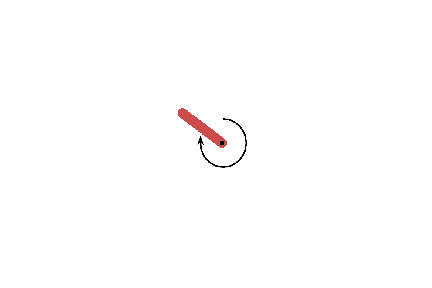
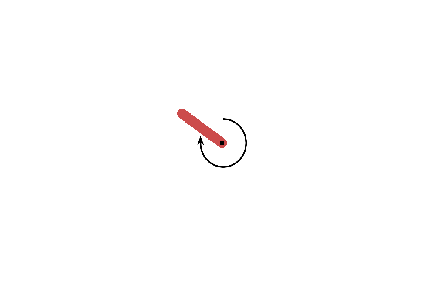
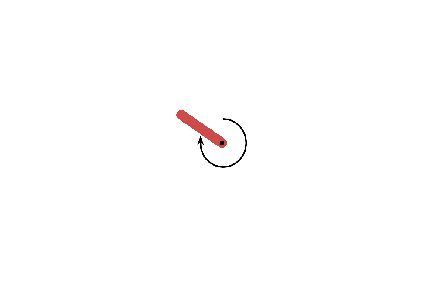
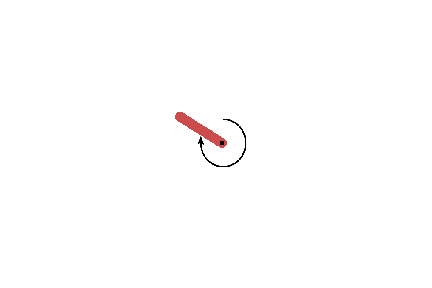
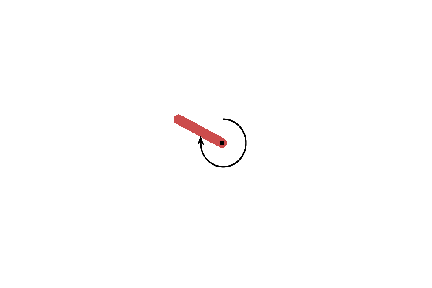
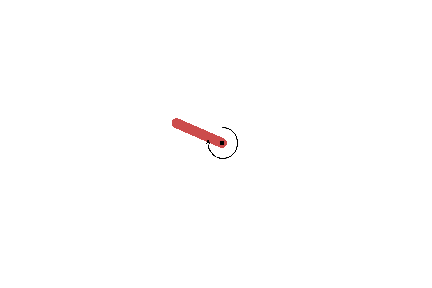
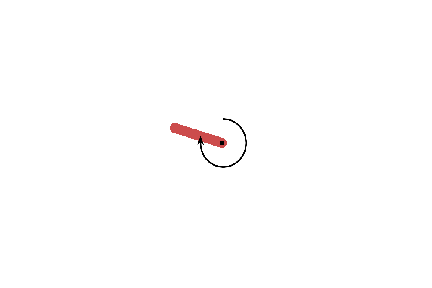
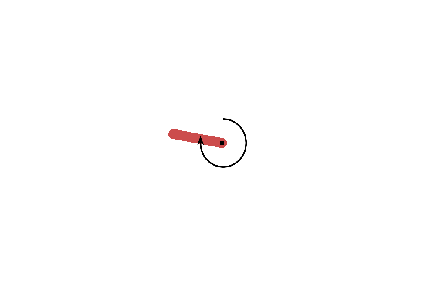
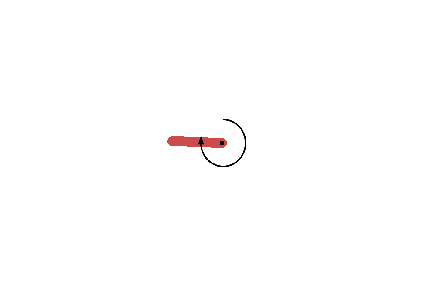
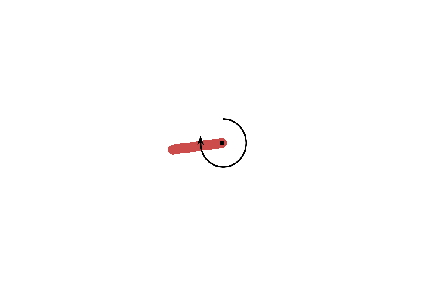
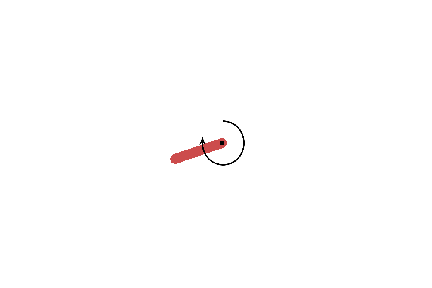
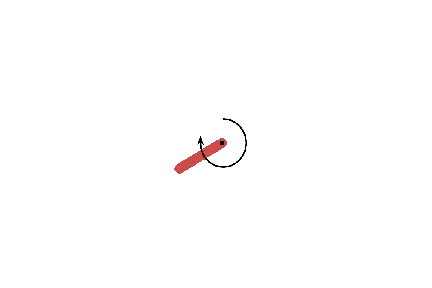
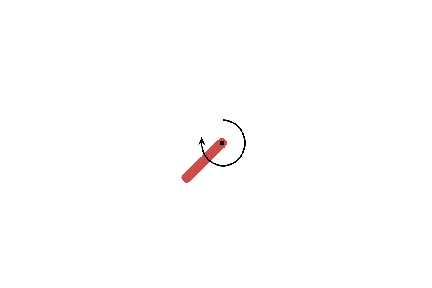
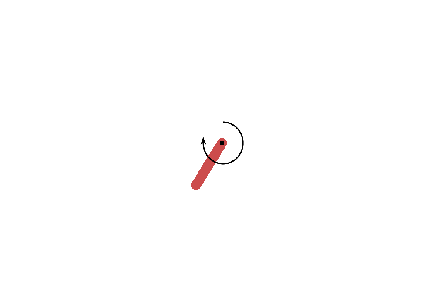
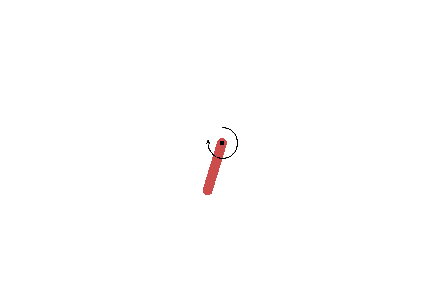
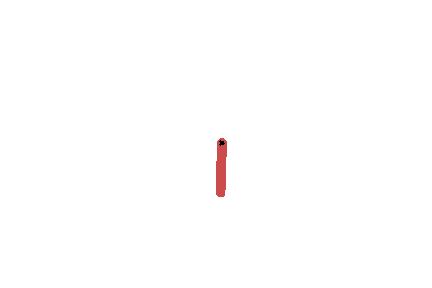
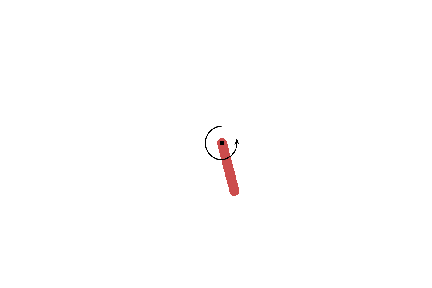
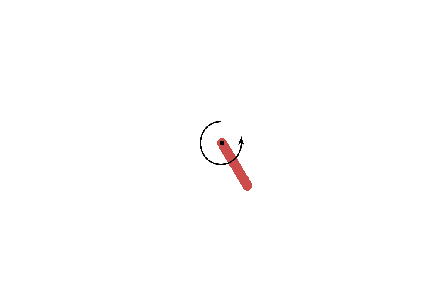
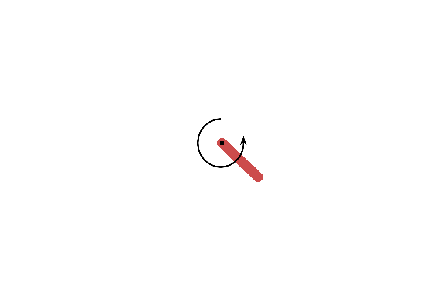
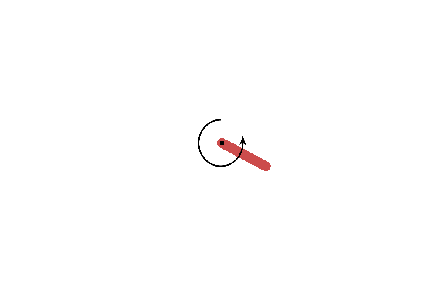
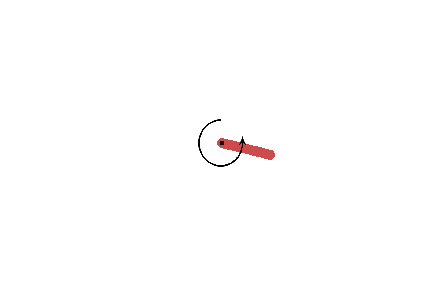
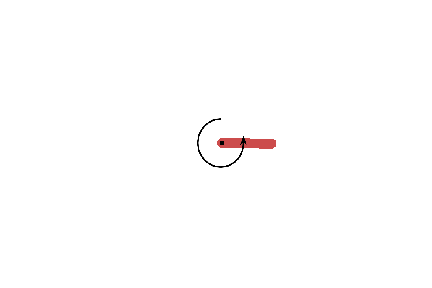
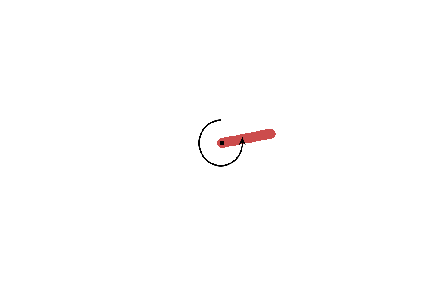
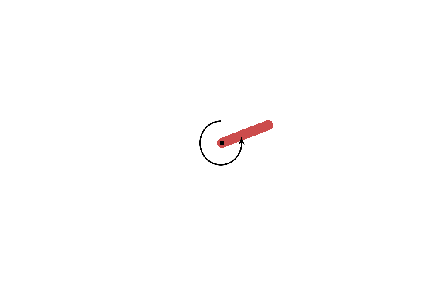
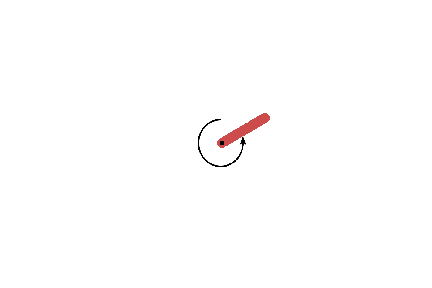
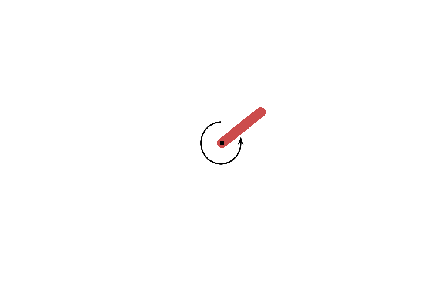
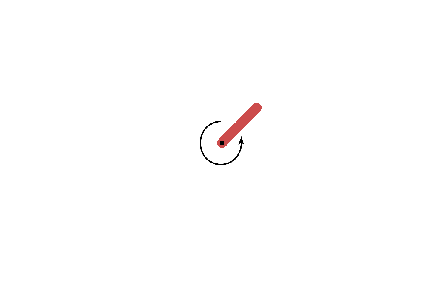
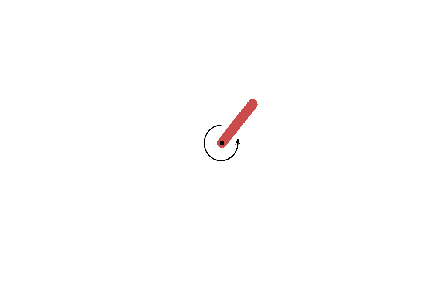
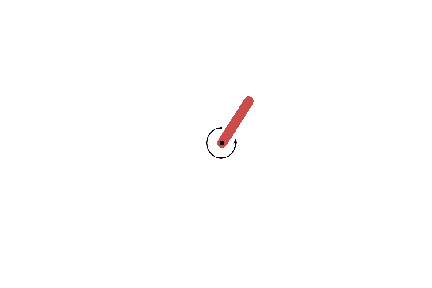
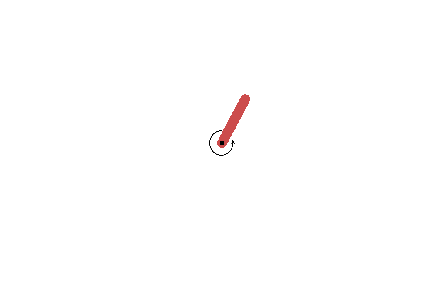
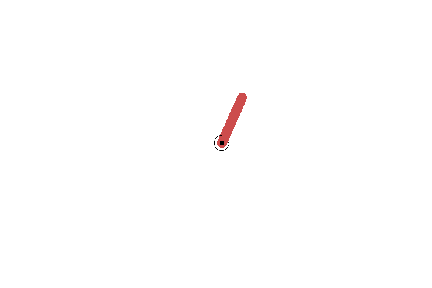
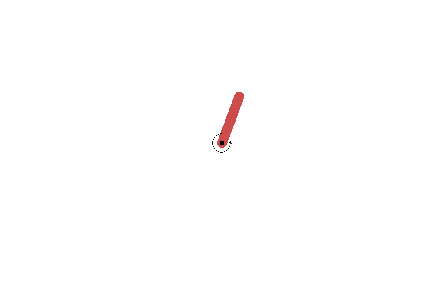
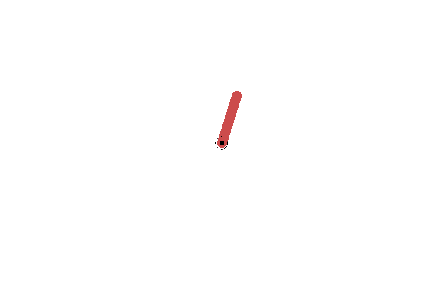
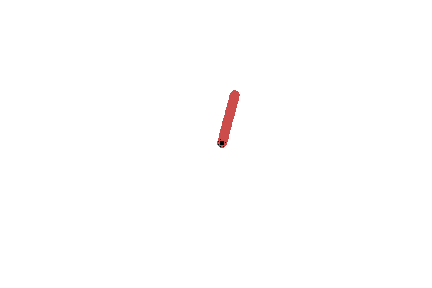
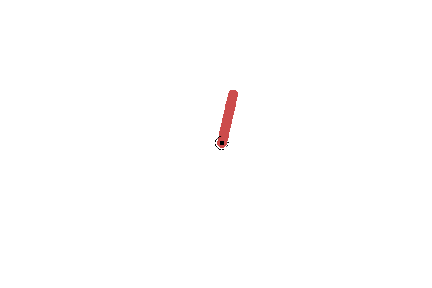
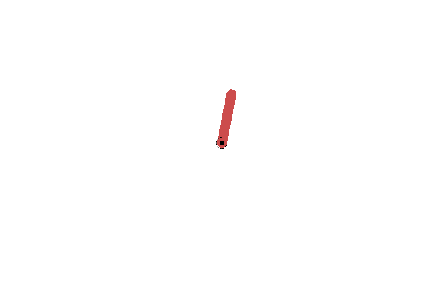
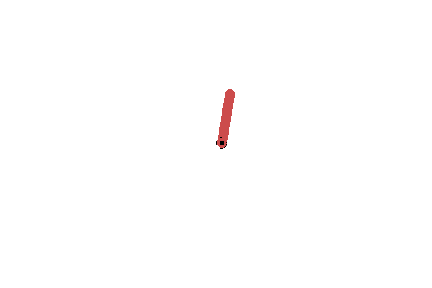
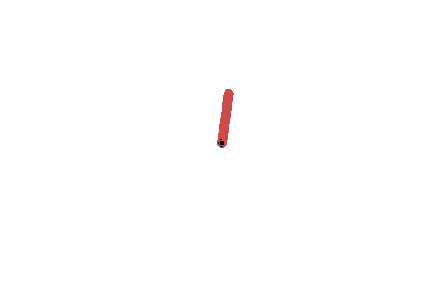
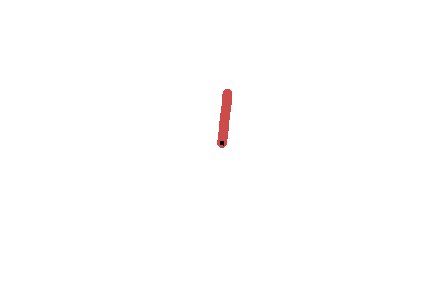
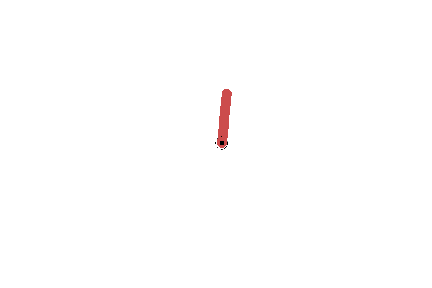
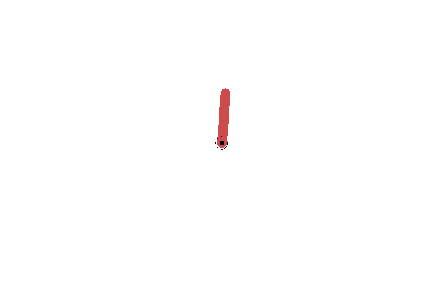
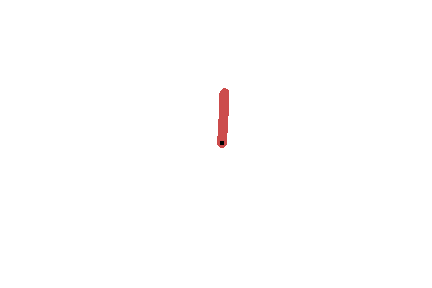
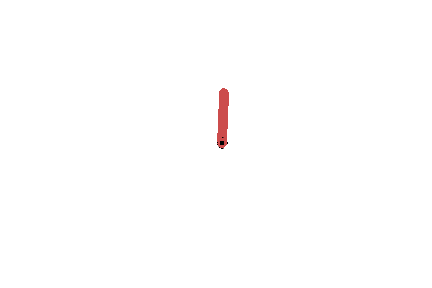
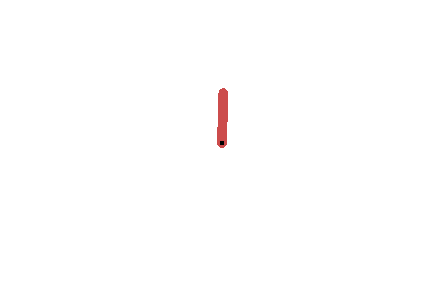
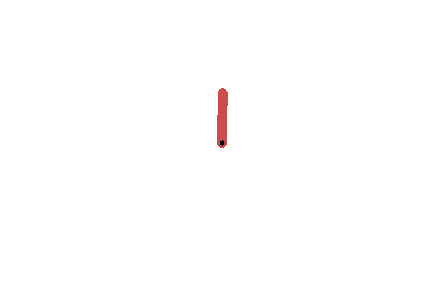
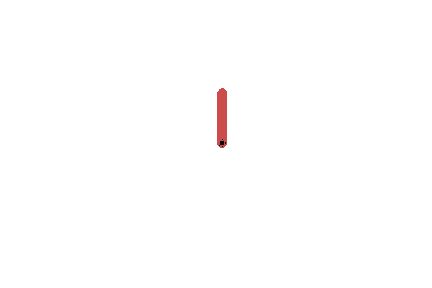
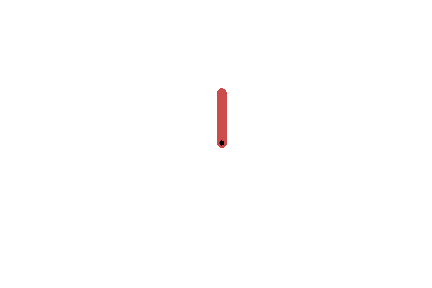
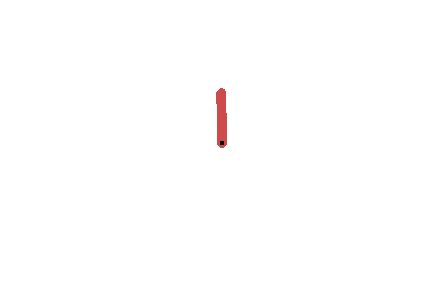
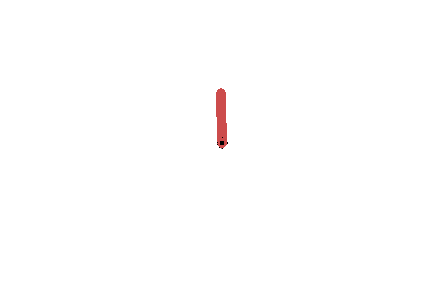
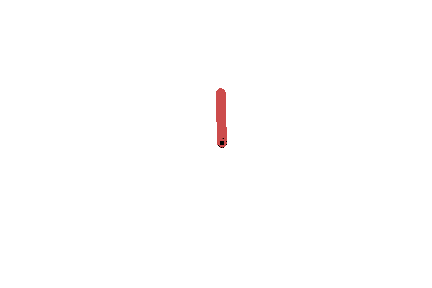
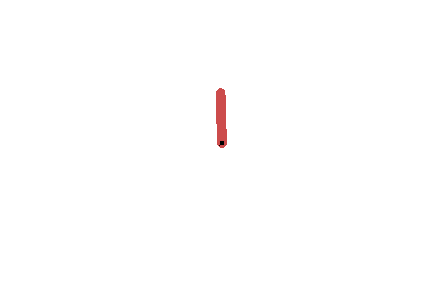
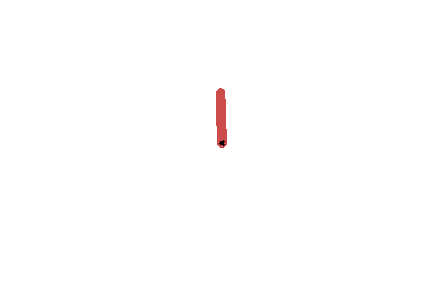
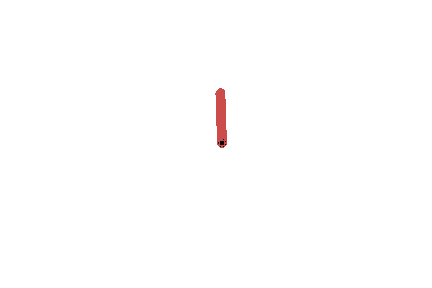
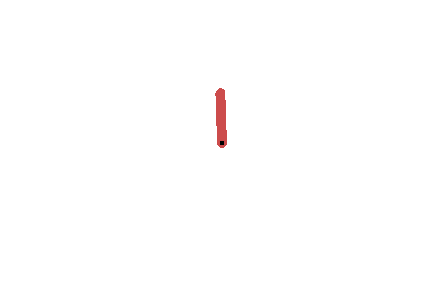
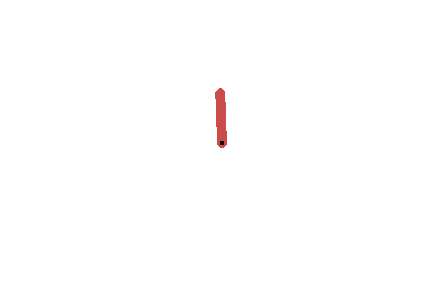
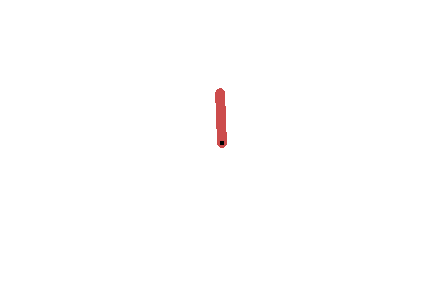
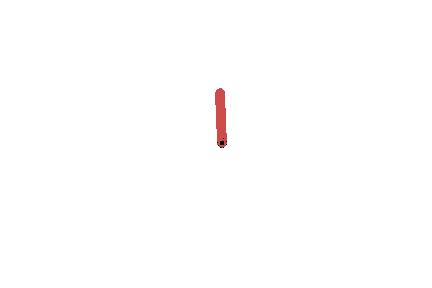
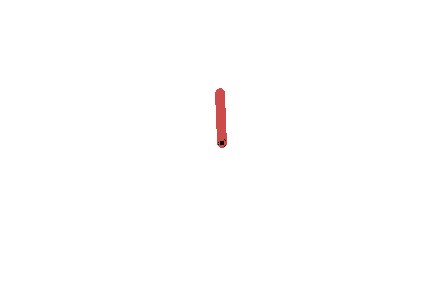
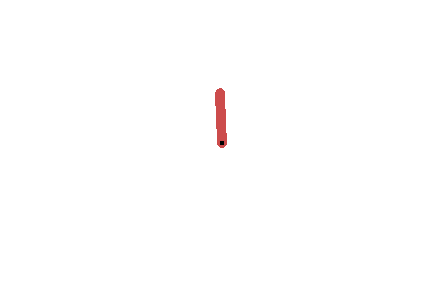
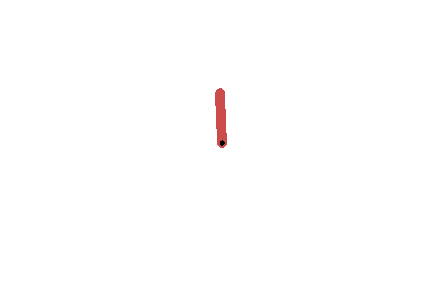
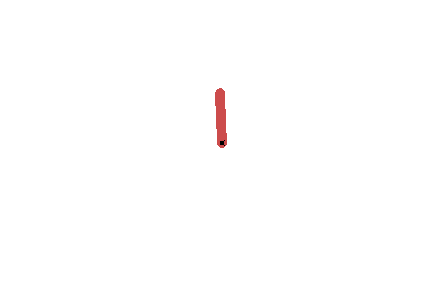
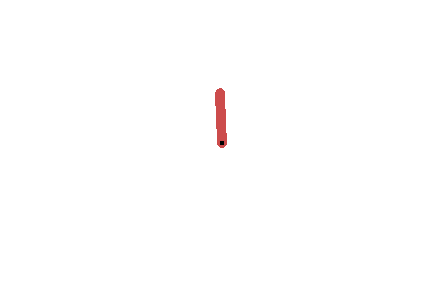
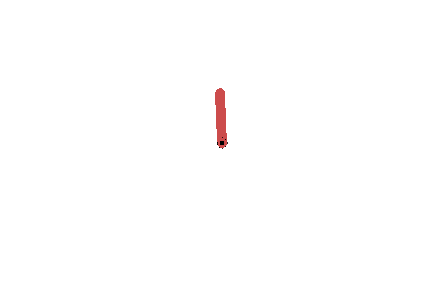
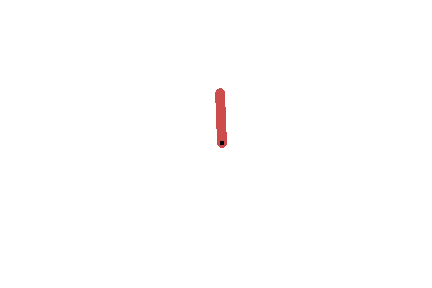
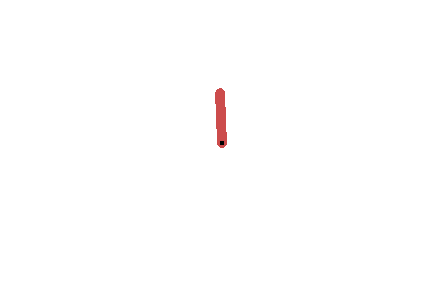
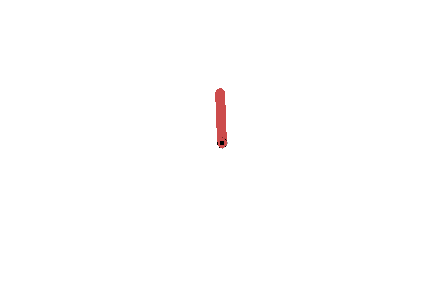
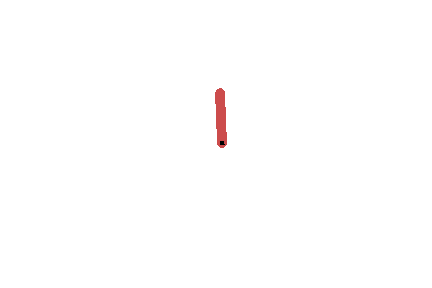
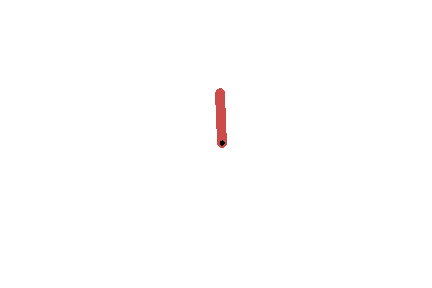
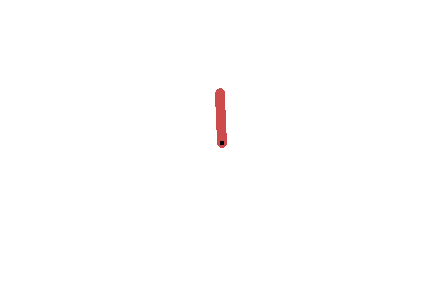
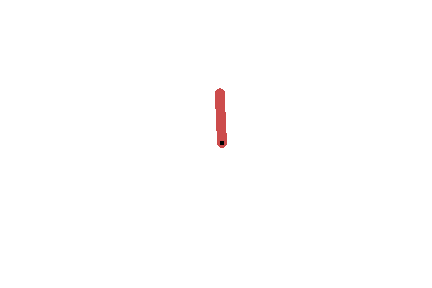
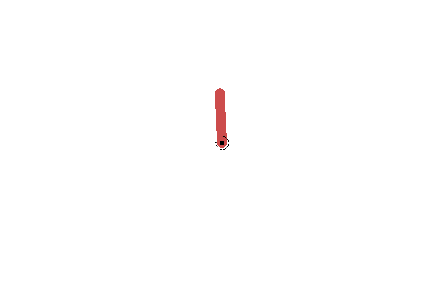
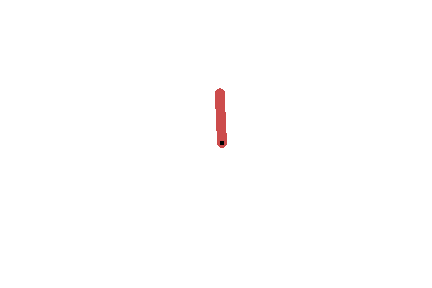
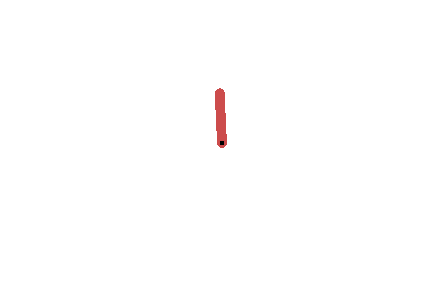
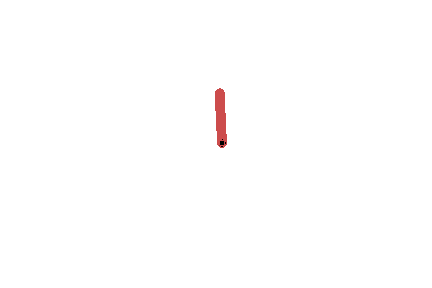
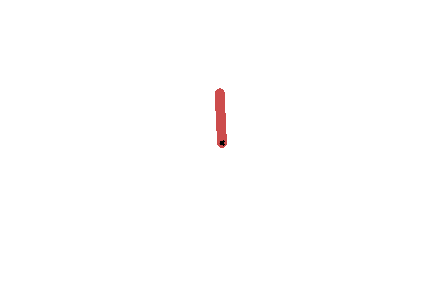
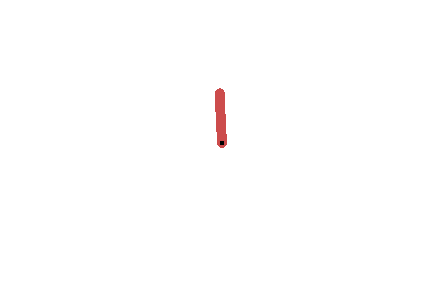
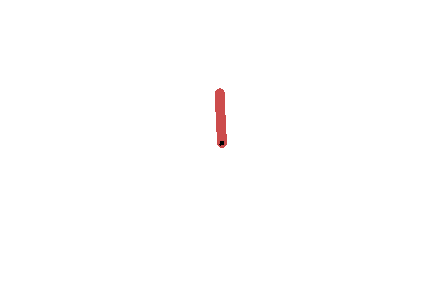
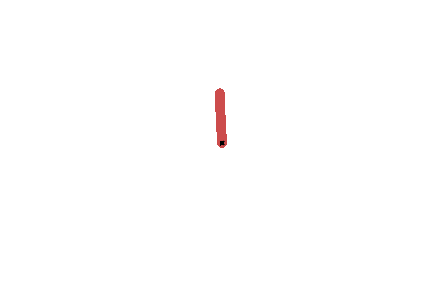
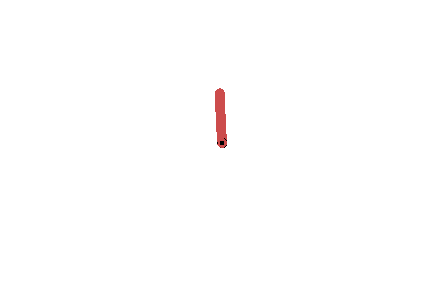
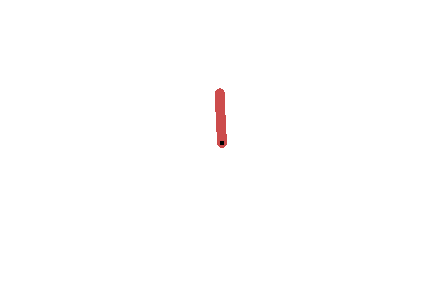
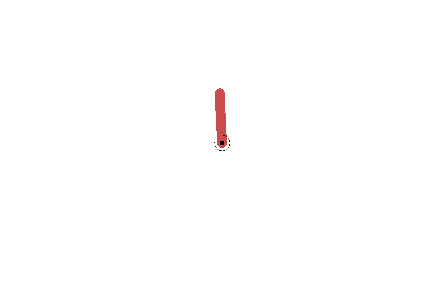
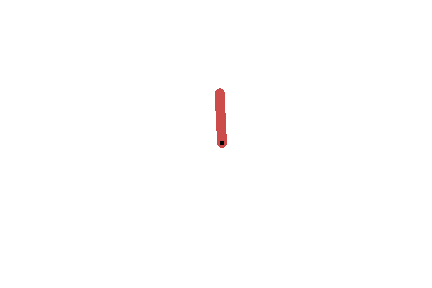
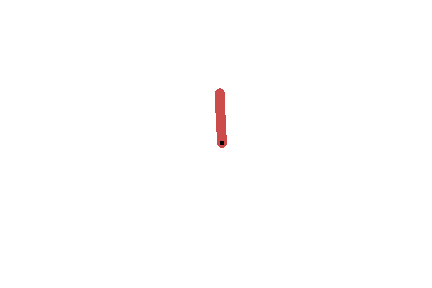
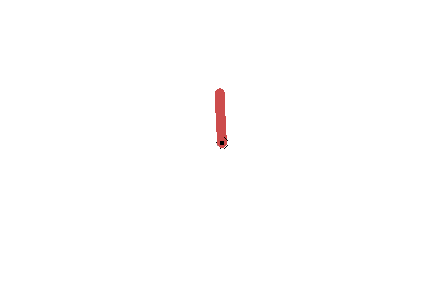
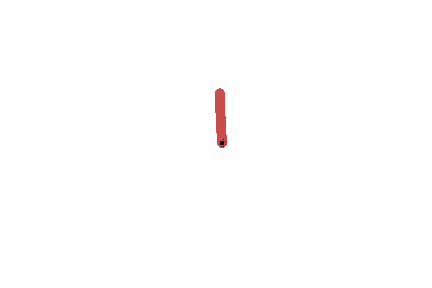
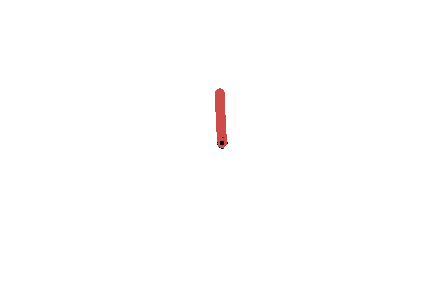
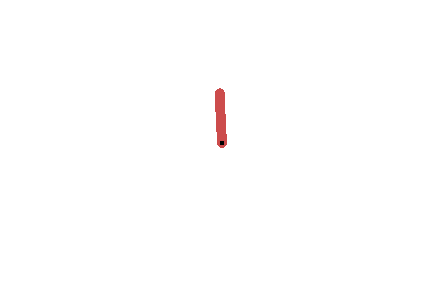
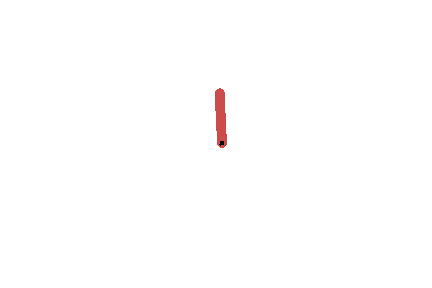
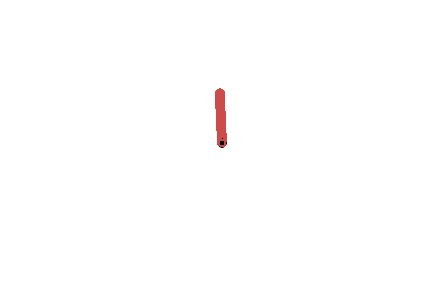
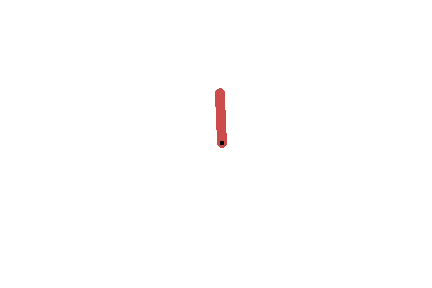
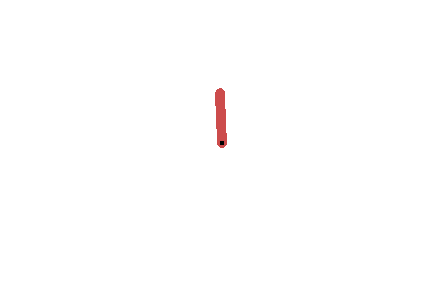
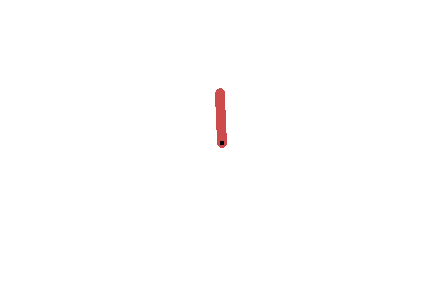
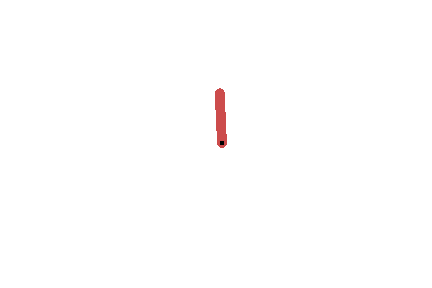
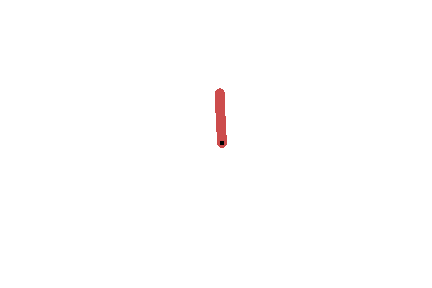
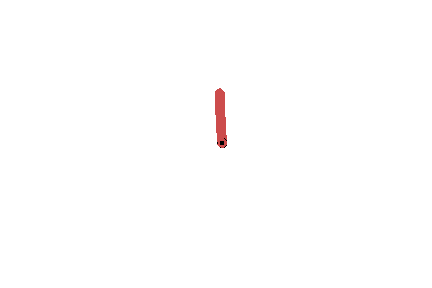
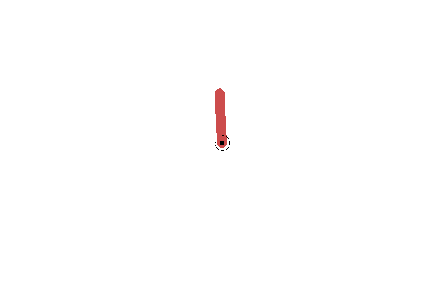
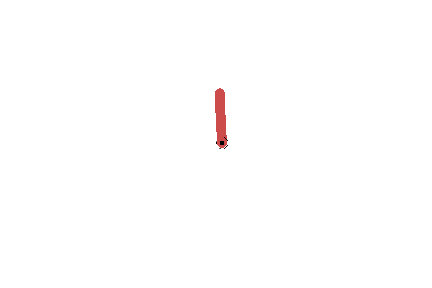
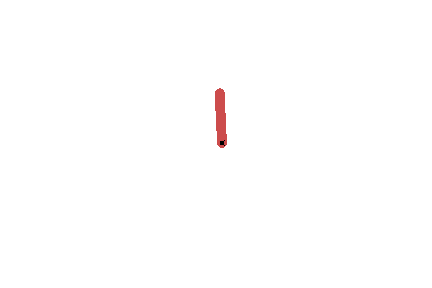
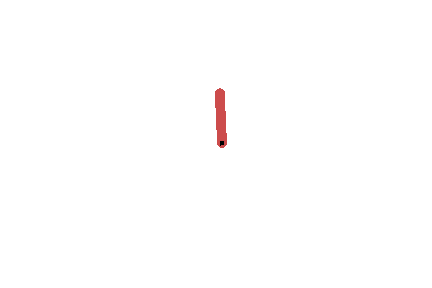
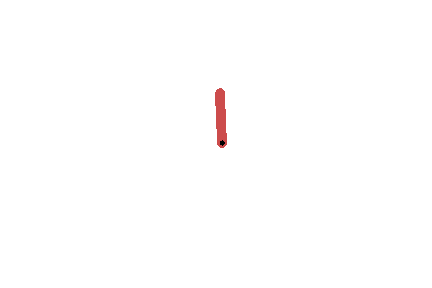
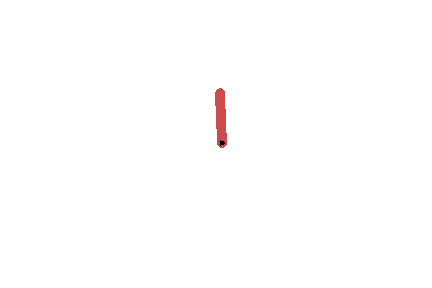
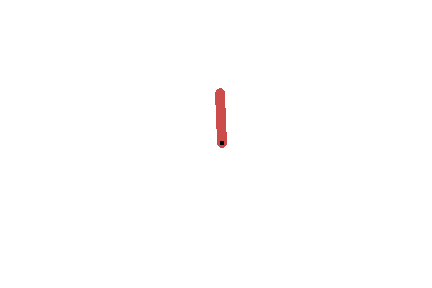
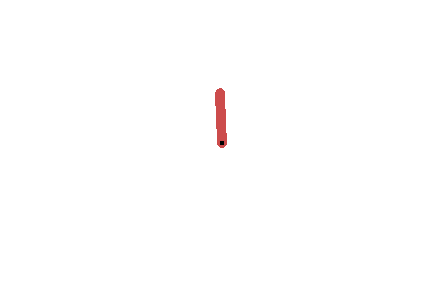

In [8]:
all_ep_r = train(env,ppo,EP_MAX,render=True)

#### YAY! We've made it!

Our little IA now knows how to stabilize a Pendulum!!! :D

## 4. Plot

Let's see how the rewards has increased across epochs

In [9]:
# Create a trace
trace = go.Scatter(
    x = np.arange(0,len(all_ep_r)),
    y = all_ep_r,
)
data = [trace]
# Plot and embed in ipython notebook!
iplot(data, filename='basic-line')

## References

1. [Proximal Policy Optimization Algorithms](https://arxiv.org/pdf/1707.06347.pdf)
2. [6.4 PPO/DPPO Proximal Policy Optimization (强化学习 Reinforcement Learning with tensorflow 教学) - Morvan](https://www.youtube.com/watch?v=_B2oMdOVVJc&t=348s&ab_channel=%E5%91%A8%E8%8E%AB%E7%83%A6)
3. [War Robots - Siraj Raval](https://www.youtube.com/watch?v=tm5kQmjfZN8&ab_channel=SirajRaval)